# Model errors and feature importances are calculated in `BJA-3.8.1`

In [356]:
import time
from collections import defaultdict
import json
import math
import random
import csv
import pickle
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import sklearn
from statsmodels.stats.multitest import fdrcorrection

print(sklearn.__version__)

1.0.2


In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

fg = fg.drop('1091_9_FBG')

fbg_cols = fg.loc[fg['original'] & fg['quant_file']].filter(regex='FBG', axis=0).index
rbg_cols = fg.loc[fg['original'] & fg['quant_file']].filter(regex='RBG', axis=0).index

In [3]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)
X_id = X_scaled.loc[:, data.loc[data['ID'] != 'Unidentified'].index]
X_id = X_id.drop(['m_104', 'm_68', 'm_135', 'm_127', 'm_115'], axis=1) # drop low conf. ID features
y_ogtt = fg.loc[data_cols, 'ogtt']

## Quick test for one model

In [371]:
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
scoring = 'neg_mean_squared_error'

model = Lasso()
rbg_scores = cross_val_score(
    model,       
    X.loc[rbg_cols],  
    y_ogtt.loc[rbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

fbg_scores = cross_val_score(
    model,       
    X.loc[fbg_cols],  
    y_ogtt.loc[fbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

In [372]:
def model_cv(model, cols, X_data=X_id, display_features=20, n_splits=6, n_repeats=200):
    cross_val = cross_validate(
        estimator=model, 
        X=X_data.loc[cols], 
        y=y_ogtt.loc[cols], 
        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'],
        cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1),
        return_estimator=True,
        return_train_score=True,
        n_jobs=7,
    )
    rdf = pd.DataFrame(cross_val)
    try:
        raw_coefs = np.sum([estimator.coef_ for estimator in rdf['estimator']], axis=0)
    except:
        raw_coefs = np.sum([estimator.feature_importances_ for estimator in rdf['estimator']], axis=0)
    coefs = pd.DataFrame(raw_coefs, index=X_data.columns, columns=['coef'])
    coefs = coefs.div(coefs.abs().max())  # Normalize between 0 and 1
    coefs = coefs.join(data['ID'])
    coefs = coefs.sort_values('coef', ascending=False, key=abs)
    q1 = round(rdf['test_r2'].quantile(0.25), 2)
    q3 = round(rdf['test_r2'].quantile(0.75), 2)
    mean = round(rdf['test_r2'].mean(), 2)
    median = round(rdf['test_r2'].median(), 2)
    print('R2 AVERAGE: ', mean)
    print('R2 MEDIAN: ', median)
    print('R2 IQR: ', q1, q3)
    print('MSE AVERAGE: ', f"{-1*rdf['test_neg_mean_squared_error'].mean():.2E}")
    plt.hist(raw_coefs / abs(raw_coefs).max(), bins=20)
    plt.title('Model normalized coefficients')
    plt.figure()
    plt.hist(rdf['test_r2'], bins=20, range=(-1, 1))
    plt.axvline(median, zorder=10, color='black')
    plt.title('Test R2 values')
#     display(coefs.iloc[0:display_features])
    return coefs, rdf, median

## What if I make a model with nothing but TGs to model what might happen with a bulk triglycerides test on blood? 

In [431]:
X_id

i,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_11,m_13,...,l_890,l_892,l_893,l_895,l_900,l_905,l_907,l_908,l_910,l_912
1091_8_FBG,1.229019,1.536198,0.846416,-0.050953,-0.269333,-1.130265,-0.266355,0.061731,0.647281,0.336152,...,-1.335528,-1.532042,-2.023310,-1.260969,-2.114683,-1.533031,-1.561124,-1.716919,-1.054728,-1.074026
1091_10_FBG,0.533221,1.174710,0.739283,0.132171,0.051373,-0.576451,-0.265027,-1.058962,0.676293,-0.953100,...,-0.797264,-0.962689,-1.083146,-0.643463,-0.387013,-0.605897,-0.508650,-0.754984,-0.749764,-0.531201
1093_8_FBG,0.492781,1.037874,0.812384,0.147746,-0.141591,-0.548014,-0.325452,0.157906,-0.241991,0.757178,...,-0.483469,-0.616040,-0.328035,-0.642461,0.467940,0.580905,0.578152,-0.154377,-0.061758,-0.029229
1093_9_FBG,-0.880181,0.788158,0.705562,0.256840,-0.341470,-0.137352,-0.414700,0.022887,1.110839,-0.376770,...,0.752943,0.258840,0.643180,0.396355,1.584158,1.658604,1.244840,0.926696,1.000001,1.152129
1093_10_FBG,-0.489524,0.535345,0.616495,-0.063402,0.285385,-0.380824,0.301753,-0.835324,-0.566014,1.550592,...,-1.024097,-0.736324,-0.518622,-0.533785,0.168858,-0.022784,-0.187658,-0.607964,-0.310183,-0.396888
1060_8_FBG,0.896561,1.178150,-2.282202,-1.169002,-1.609683,-1.470286,-1.785857,-1.256750,0.209928,0.637174,...,0.004508,0.246631,0.332692,0.568833,0.763527,0.956112,0.487064,0.173345,0.733802,0.695945
1060_9_FBG,1.324875,0.775060,-1.672677,0.333861,-0.632751,-1.436959,-0.644096,-0.890270,-0.385268,0.912660,...,-0.071204,0.313844,0.062509,0.789359,0.771222,1.059484,0.475486,-0.274277,0.602978,1.118261
1060_10_FBG,-0.047244,1.338707,0.753079,-0.788491,-0.330167,-0.988757,-0.328765,-1.359093,0.538141,0.860090,...,-0.996064,-1.069457,-1.213053,-0.683848,-1.189813,-0.575565,-0.863891,-1.297697,-1.514126,-0.381498
1062_8_FBG,2.035057,1.328345,-0.886567,0.374126,-0.894183,-0.765664,-1.101437,-0.355523,1.054275,1.007081,...,-0.835489,-0.821846,-1.029539,-0.909917,-0.440379,-0.588062,-0.936653,-1.045920,-1.024733,-0.968693
1062_9_FBG,1.171443,0.543054,-0.459645,-0.684523,-0.625548,-0.918553,-0.512926,-0.746351,1.769948,2.027789,...,-0.455226,-0.475497,-0.817643,-0.366671,-0.751884,-0.343151,-0.991980,-0.841184,-0.620887,-0.494748


R2 AVERAGE:  0.45
R2 MEDIAN:  0.65
R2 IQR:  0.4 0.75
MSE AVERAGE:  4.91E+07


,coef,ID
i,,
l_617,-1.000000,TG 18:1_20:5_20:5
l_852,-0.959839,TG 53:2
l_681,0.933339,TG 54:6
l_860,0.915528,TG 18:0_18:0_20:4
l_716,0.837515,TG 60:10
l_702,0.759360,TG 18:0_20:5_20:4
l_646,0.701278,TG 54:7
l_765,0.670248,TG 52:4
l_714,-0.651077,TG 16:0_16:0_20:5


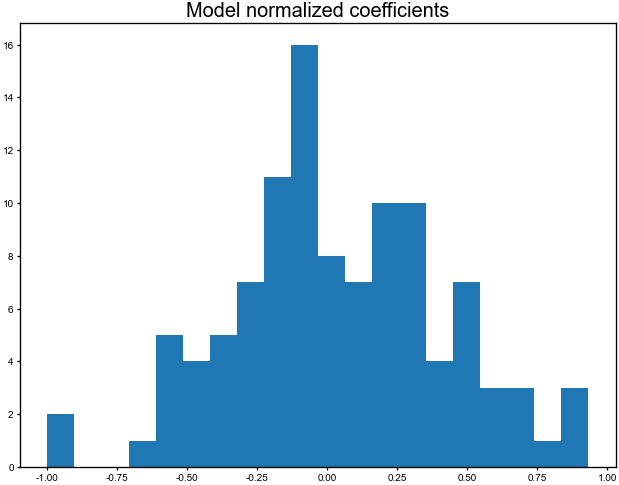

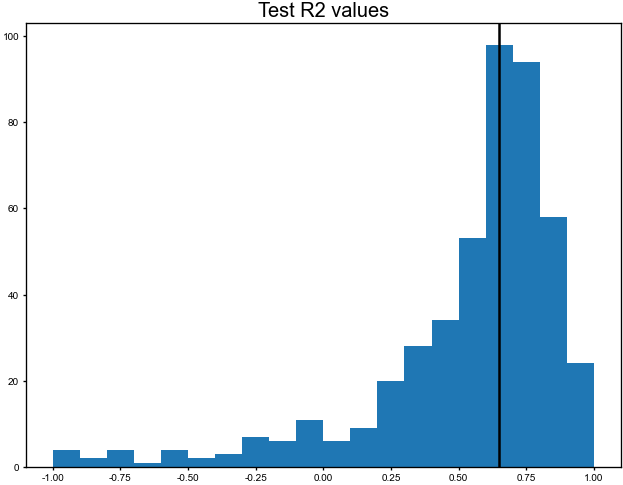

In [433]:
testc, testr, testm = model_cv(
#     Lasso(alpha=10), 
    LinearRegression(),
    X_data=X_id.loc[:, (data['molec_class'] == 'TG')],
    cols=fbg_cols, n_repeats=80)
testc.iloc[:50]

# Save time by skipping the next cell and reading the `.pickle` file 

R2 AVERAGE:  0.49
R2 MEDIAN:  0.71
R2 IQR:  0.53 0.82
MSE AVERAGE:  4.20E+07


KeyboardInterrupt: 

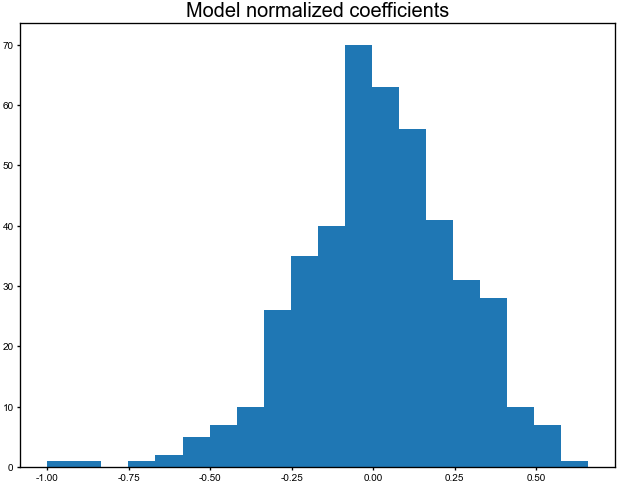

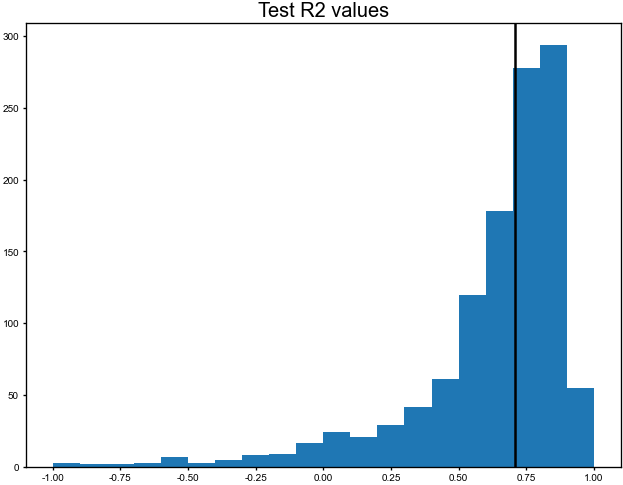

In [375]:
models = {
    'ols': LinearRegression(),
    'lasso': Lasso(alpha=30),
    'ridge': Ridge(alpha=100),
    'en'   : ElasticNet(alpha=500, l1_ratio=0.999),
#     'svm': (SVR(kernel='linear', C=1), X_scaled),
    'pls'  : PLSRegression(),
    'rf'   : RandomForestRegressor(n_estimators=200, max_features=100, random_state=42),
}

r = {}
for model_name, model in models.items():
    r[model_name] = {}
    for bg_type, cols in [('rbg', rbg_cols), ('fbg', fbg_cols)]:
        d = r[model_name][bg_type] = {}
        coefs, rdf, median_r2 = model_cv(model, cols=cols)
        d['coefs'] = coefs
        d['rdf'] = rdf
        d['r2'] = median_r2

In [417]:
est = 1005
for est in range(0, 100):
    print(pd.DataFrame(rdf.loc[est, 'estimator'].coef_, index=rdf.loc[est, 'estimator'].feature_names_in_).loc['l_1'].values[0])

-32.13485504720549
-44.96364705781873
-53.12821178054415
-17.727755541498645
-36.1680585711356
-92.16449086840765
-74.15040300896189
-17.28029522278254
-228.23361457016907
-120.54883226966464
102.54791819366298
33.248306206799306
-102.37606265729895
-45.634551463588735
-156.07957375194127
-18.99154690857769
-7.904958764396476
14.408985950989916
-30.442936037066993
-60.494071309333826
-138.0043372509389
42.584707188202216
-101.25919691393176
-60.25316932727348
-78.58761323506296
66.57339820406176
-64.32461550660446
31.308482385540348
-18.954945679706313
-145.49111102530287
-178.58156317587571
-67.05638558728091
41.98109890293132
-38.63800134926054
-96.33553599581793
7.586197497215366
-135.52599510138813
-28.60164688494337
-144.81680775518342
7.865566961321058
42.93283119054069
20.865982838447067
26.136515977889054
-79.26740154112937
33.35040829148893
-80.60783907233622
-185.22447847035804
26.02108839813141
22.0989193172488
-66.89336704895169
-88.20420751319412
-46.11716043220064
-43.545

In [425]:
# Save to pickle 
# with open('../data/processed/model_fits/fasted_vs_fed_models.pickle', 'wb') as f:
#     pickle.dump(r, f)
    
# Open pickle 
#### TAKES ABOUT 30 SECONDS TO READ
with open('../data/processed/model_fits/fasted_vs_fed_models.pickle', 'rb') as f:
    r = pickle.load(f)

In [6]:
r2s = [
    [r['ols']  ['rbg']['r2'],   r['ols']  ['fbg']['r2'],],
    [r['lasso']['rbg']['r2'],   r['lasso']['fbg']['r2'],],
    [r['ridge']['rbg']['r2'],   r['ridge']['fbg']['r2'],],
    [r['en']   ['rbg']['r2'],   r['en']   ['fbg']['r2'],],
    [r['pls']  ['rbg']['r2'],   r['pls']  ['fbg']['r2'],],
    [r['rf']   ['rbg']['r2'],   r['rf']   ['fbg']['r2'],],
]
r2s = pd.DataFrame(r2s, columns=['Non-fasted', 'Fasted'])
r2s['model'] = ['ols', 'lasso', 'ridge', 'en', 'pls', 'rf']
r2s = r2s.melt(value_vars=['Fasted', 'Non-fasted'], id_vars='model', value_name='R2', var_name='Sampling')
x_pos = [0, 1, 2, 3, 4, 5]
r2s['x'] = x_pos * 2
r2s

,model,Sampling,R2,x
0,ols,Fasted,0.56,0
1,lasso,Fasted,0.37,1
2,ridge,Fasted,0.53,2
3,en,Fasted,0.52,3
4,pls,Fasted,0.59,4
5,rf,Fasted,0.49,5
6,ols,Non-fasted,0.71,0
7,lasso,Non-fasted,0.46,1
8,ridge,Non-fasted,0.70,2
9,en,Non-fasted,0.67,3


## Count number of features above 0.02 coef

In [426]:
for model in models:
    for bg_type in ['rbg', 'fbg']:
        thing = r[model][bg_type]['coefs']
        
        num = len(thing.loc[thing['coef'].abs() > 0.02])
        print(model, bg_type, num)


ols rbg 412
ols fbg 412
lasso rbg 80
lasso fbg 67
ridge rbg 405
ridge fbg 409
en rbg 107
en fbg 102
pls rbg 417
pls fbg 414
rf rbg 149
rf fbg 67


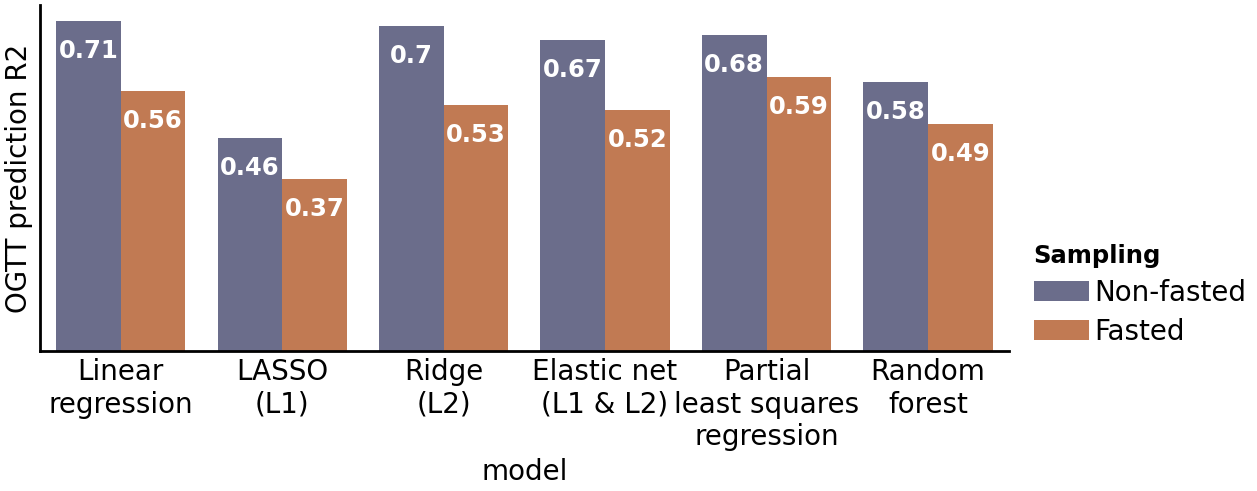

In [52]:
fig, ax = plt.subplots(dpi=250, figsize=(5, 1.8))
sns.barplot(
    data=r2s, x='model', y='R2', hue='Sampling', palette=colors, hue_order=['Non-fasted', 'Fasted'], 
    saturation=0.99, alpha=1,
)

# ax.bar(
#     x='x', height='R2', data=r2s
# )

ax.set_xticks(ax.get_xticks(), 
              labels=['Linear\nregression', 'LASSO\n(L1)', 'Ridge\n(L2)', 
                      'Elastic net\n(L1 & L2)', 'Partial\nleast squares\nregression', 'Random\nforest'])
# ax.set_yticks([0, 0.25, 0.5, 0.75])
ax.set_yticks([])
ax.tick_params(pad=2, length=0, labelsize=8)
ax.set_ylabel('OGTT prediction R2')


for i, row in r2s.iterrows():
    offset = 0.2
    x_loc = row['x'] + (-offset if row['Sampling'] == 'Non-fasted' else offset)
    r2 = row['R2']
    y_loc = r2 - 0.09
    ax.text(x_loc, y_loc, r2, color='white', fontsize=7, fontweight='bold', va='bottom', ha='center')

legend = ax.legend(
    loc=(1.02, 0), title='Sampling', 
    title_fontproperties=dict(size=src.plots.LEGEND_TITLE_FONTSIZE, weight='bold'),
#           fontsize=8, borderpad=0.5, labelspacing=0.4, handlelength=2, handletextpad=0.5
         )
legend._legend_box.align = 'left'
sns.despine()
# plt.savefig('../reports/figures/Figure6/model_R2_barplots.pdf', bbox_inches='tight', )

In [8]:
df = r['en']['rbg']['coefs']

df = df.loc[df['coef'] > 0.01]
df = df.join(data[['molec_class', 'superclass', 'Type']])
# re-normalize (because an Unidentified feature had the highest coefficient)
df['coef'] = df['coef'] / df['coef'].max()
df['i'] = df.index
df['color'] = df['superclass'].map(colors)
df['rank'] = df['coef'].rank(ascending=False)

mdf = df.loc[df['Type'] == 'metabolite']
ldf = df.loc[df['Type'] == 'lipid']

df

,coef,ID,molec_class,superclass,Type,i,color,rank
i,,,,,,,,
l_505,1.000000,Plasmanyl-PC O-20:0_20:4,Plasmanyl-PC,Phospholipid,lipid,l_505,"[0.34765625, 0.62890625, 0.3046875]",1.0
l_435,0.912957,SM d37:1,SM,Sphingolipid,lipid,l_435,"[0.9453125, 0.5546875, 0.16796875]",2.0
l_648,0.765600,TG 18:1_22:6_22:6,TG,Glycerolipid,lipid,l_648,"[0.6875, 0.4765625, 0.6328125]",3.0
l_195,0.643920,SM d36:3,SM,Sphingolipid,lipid,l_195,"[0.9453125, 0.5546875, 0.16796875]",4.0
l_794,0.630624,TG 58:7,TG,Glycerolipid,lipid,l_794,"[0.6875, 0.4765625, 0.6328125]",5.0
...,...,...,...,...,...,...,...,...
l_414,0.017967,Plasmenyl-PE P-18:0_22:6,Plasmenyl-PE,Phospholipid,lipid,l_414,"[0.34765625, 0.62890625, 0.3046875]",79.0
l_319,0.015699,PC 18:0_20:5,PC,Phospholipid,lipid,l_319,"[0.34765625, 0.62890625, 0.3046875]",80.0
l_283,0.014910,PC O-36:3,Plasmenyl-PC,Phospholipid,lipid,l_283,"[0.34765625, 0.62890625, 0.3046875]",81.0


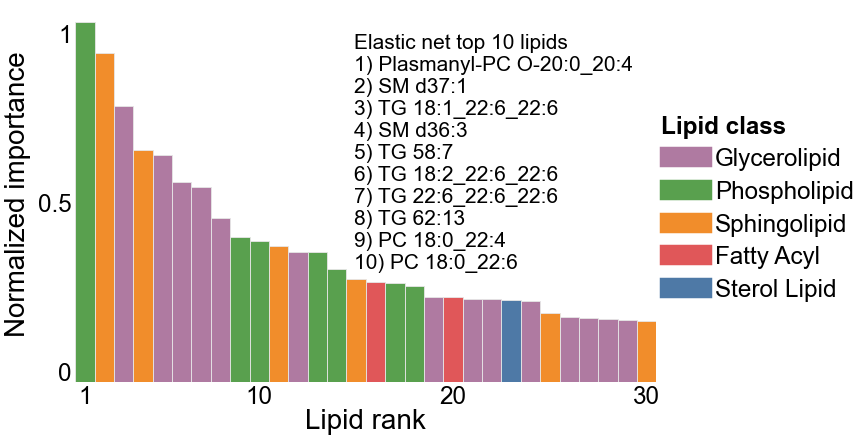

In [9]:
bdf = ldf

fig, ax = plt.subplots(dpi=250, figsize=(3, 2))
plt.bar(range(len(bdf)), bdf['coef'], color=bdf['color'], edgecolor='0.9', linewidth=0.25,
        width=1)


ax.set_xticks(ticks=[0] + list(range(9, len(bdf), 10)), 
              labels=[1] + list(range(10, len(bdf), 10)), 
              fontsize=5)
ax.set_yticks([0.03, 0.5, 0.97], [0, 0.5, 1])
ax.tick_params(length=0, pad=1, labelsize=7)
# ax.
ax.set_xlabel('Lipid rank', fontsize=8, labelpad=0)
ax.set_ylabel('Normalized importance', fontsize=8, labelpad=2)
ax.set_xlim(-0.5, 29.5)

### Add text labels to the top 10 metabolites
# for counter, (i, row) in enumerate(bdf.iloc[:10].iterrows()):
#     ax.annotate(text=row['ID'], xy=(counter, row['coef']), 
#                 xytext=(counter+5, row['coef']+0.05),
# #                 arrowprops=dict(arrowstyle='-', relpos=(0, 0.5), lw=1, color='0.5'),
#                 bbox=dict(pad=-5, facecolor='none', edgecolor='none'),
#                 fontsize=5, annotation_clip=True, ha='left', va='bottom')
### Make list of top 10
top = '\n'.join([f'{x }) {id_}' for x, id_ in zip(range(1, 11), bdf.iloc[:10]['ID'])])
top = 'Elastic net top 10 lipids\n' + top
ax.text(0.48, 0.29, top, va='bottom', ha='left', fontsize=6, transform=ax.transAxes)
    
# Make legend
handles, labels = [], []
for cls in ['Glycerolipid', 'Phospholipid', 'Sphingolipid', 'Fatty Acyl', 'Sterol Lipid']:
    handles.append(plt.matplotlib.patches.Patch(color=colors[cls]))
    labels.append(cls)
legend = ax.legend(handles, labels, loc=(1, 0.2), fontsize=7, title='Lipid class',
          title_fontproperties=dict(size=src.plots.LEGEND_TITLE_FONTSIZE, weight='bold'),
#           fontsize=6, borderpad=0.5, labelspacing=0.4, handlelength=2, handletextpad=0.5
         )
legend._legend_box.align = 'left'
sns.despine(left=True, bottom=True)
# plt.savefig('../reports/figures/Figure6/lipid_coefficients_barplot.pdf', bbox_inches='tight', facecolor='white')

# Horizontal bars comparing fasted vs fed in Elastic Net

In [263]:
fdrcorrection([0.5, 0.001])[1]

array([0.5  , 0.002])

In [275]:
corrdf = []
for i in data.index:
    fbg_corr, fbg_p = pearsonr(data.loc[i, fbg_cols], fg.loc[fbg_cols, 'ogtt'])
    rbg_corr, rbg_p = pearsonr(data.loc[i, rbg_cols], fg.loc[rbg_cols, 'ogtt'])
    corrdf.append({'i': i, 'rbg_corr': rbg_corr, 'rbg_p': rbg_p, 'fbg_corr': fbg_corr, 'fbg_p': fbg_p})
corrdf = pd.DataFrame(corrdf).set_index('i')

corrdf['rbg_q'] = fdrcorrection(corrdf['rbg_p'])[1]
corrdf['fbg_q'] = fdrcorrection(corrdf['fbg_p'])[1]


corrdf['rbg_corr_signif'] = corrdf['rbg_q'] < 0.05
corrdf['fbg_corr_signif'] = corrdf['fbg_q'] < 0.05

In [281]:
def corr_sign_signif(q, corr):
    if q > 0.05: 
        return 'ns'
    elif corr < 0:
        return '-'
    elif corr > 0:
        return '+'

corrdf['rbg_corr_sign'] = corrdf[['rbg_q', 'rbg_corr']].apply(lambda x: corr_sign_signif(x[0], x[1]), axis=1)
corrdf['fbg_corr_sign'] = corrdf[['fbg_q', 'fbg_corr']].apply(lambda x: corr_sign_signif(x[0], x[1]), axis=1)
corrdf

,rbg_corr,rbg_p,fbg_corr,fbg_p,rbg_q,fbg_q,rbg_corr_signif,fbg_corr_signif,rbg_corr_sign,fbg_corr_sign
i,,,,,,,,,,
m_0,0.546648,1.774542e-03,0.519073,0.003910,0.005187,0.036488,True,True,+,+
m_1,0.818998,3.159016e-08,0.036441,0.851133,0.000001,0.918963,True,False,+,ns
m_2,-0.142459,4.526725e-01,-0.034559,0.858745,0.559487,0.922296,False,False,ns,ns
m_3,-0.155270,4.126169e-01,-0.344277,0.067430,0.525298,0.220950,False,False,ns,ns
m_4,-0.142954,4.510871e-01,-0.419337,0.023551,0.558303,0.112484,False,False,ns,ns
...,...,...,...,...,...,...,...,...,...,...
l_912,0.684674,3.003979e-05,0.048279,0.803593,0.000203,0.895069,True,False,+,ns
l_913,0.642011,1.311126e-04,-0.218628,0.254531,0.000672,0.482684,True,False,+,ns
l_914,0.549330,1.666406e-03,-0.285556,0.133203,0.004922,0.333955,True,False,+,ns


In [289]:
hdf = r['en']['rbg']['coefs']
hdf = hdf.merge(r['en']['fbg']['coefs']['coef'], left_index=True, right_index=True, suffixes=['_rbg', '_fbg'])
hdf = hdf.join(data[['superclass', 'molec_class', 'Type']])
hdf = hdf.join(corrdf[['rbg_corr_sign', 'fbg_corr_sign']])
hdf = hdf.drop(['m_139', 'm_107', 'm_66'])
hdf[['abs_coef_rbg', 'abs_coef_fbg']] = hdf[['coef_rbg', 'coef_fbg']].abs()
hdf['rbg_coef_sign'] = hdf['coef_rbg'].apply(lambda x: ('+' if x > 0 else '-'))
hdf['fbg_coef_sign'] = hdf['coef_fbg'].apply(lambda x: ('+' if x > 0 else '-'))

hdf = hdf.sort_values('abs_coef_rbg', ascending=False)
hdf['y_pos'] = range(0, -1*len(hdf), -1)
hdf['rbg_height'] = -1 * hdf['abs_coef_rbg']
hdf['fbg_height'] = hdf['abs_coef_fbg']

hdf['color'] = hdf['superclass'].map(colors)
# hdf.loc[hdf['Type'] == 'metabolite', 'color'] = hdf.loc[hdf['Type'] == 'metabolite', 'Type'].map(colors)
hdf.loc[hdf['Type'] == 'metabolite', 'color'] = hdf.loc[hdf['Type'] == 'metabolite', 'Type'].map({'metabolite': (0.5, 0.5, 0.5)})
hdf['color_tuples'] = hdf['color'].apply(lambda x: tuple(x))

hdf = hdf.iloc[:30]
hdf

,coef_rbg,ID,coef_fbg,superclass,molec_class,Type,rbg_corr_sign,fbg_corr_sign,abs_coef_rbg,abs_coef_fbg,rbg_coef_sign,fbg_coef_sign,y_pos,rbg_height,fbg_height,color,color_tuples
i,,,,,,,,,,,,,,,,,
l_844,-1.000000,CE 18:1,-0.698057,Sterol Lipid,CE,lipid,-,-,1.000000,0.698057,-,-,0,-1.000000,0.698057,"[0.3046875, 0.47265625, 0.65234375]","(0.3046875, 0.47265625, 0.65234375)"
l_134,-0.842531,FA 18:0,-0.283176,Fatty Acyl,FA,lipid,ns,ns,0.842531,0.283176,-,-,-1,-0.842531,0.283176,"[0.87890625, 0.33984375, 0.34765625]","(0.87890625, 0.33984375, 0.34765625)"
l_505,0.836194,Plasmanyl-PC O-20:0_20:4,0.501785,Phospholipid,Plasmanyl-PC,lipid,+,+,0.836194,0.501785,+,+,-2,-0.836194,0.501785,"[0.34765625, 0.62890625, 0.3046875]","(0.34765625, 0.62890625, 0.3046875)"
l_435,0.763410,SM d37:1,0.000056,Sphingolipid,SM,lipid,+,ns,0.763410,0.000056,+,+,-3,-0.763410,0.000056,"[0.9453125, 0.5546875, 0.16796875]","(0.9453125, 0.5546875, 0.16796875)"
l_186,-0.676794,PC 38:7,0.016780,Phospholipid,PC,lipid,-,ns,0.676794,0.016780,-,+,-4,-0.676794,0.016780,"[0.34765625, 0.62890625, 0.3046875]","(0.34765625, 0.62890625, 0.3046875)"
l_648,0.640190,TG 18:1_22:6_22:6,0.002148,Glycerolipid,TG,lipid,+,+,0.640190,0.002148,+,+,-5,-0.640190,0.002148,"[0.6875, 0.4765625, 0.6328125]","(0.6875, 0.4765625, 0.6328125)"
l_195,0.538442,SM d36:3,0.007383,Sphingolipid,SM,lipid,+,ns,0.538442,0.007383,+,+,-6,-0.538442,0.007383,"[0.9453125, 0.5546875, 0.16796875]","(0.9453125, 0.5546875, 0.16796875)"
l_794,0.527325,TG 58:7,0.000047,Glycerolipid,TG,lipid,+,ns,0.527325,0.000047,+,+,-7,-0.527325,0.000047,"[0.6875, 0.4765625, 0.6328125]","(0.6875, 0.4765625, 0.6328125)"
m_34,-0.510718,"N6,N6,N6-Trimethyl-L-lysine",-0.004437,Amino acid derivative,Amino acid derivative,metabolite,ns,ns,0.510718,0.004437,-,-,-8,-0.510718,0.004437,"(0.5, 0.5, 0.5)","(0.5, 0.5, 0.5)"


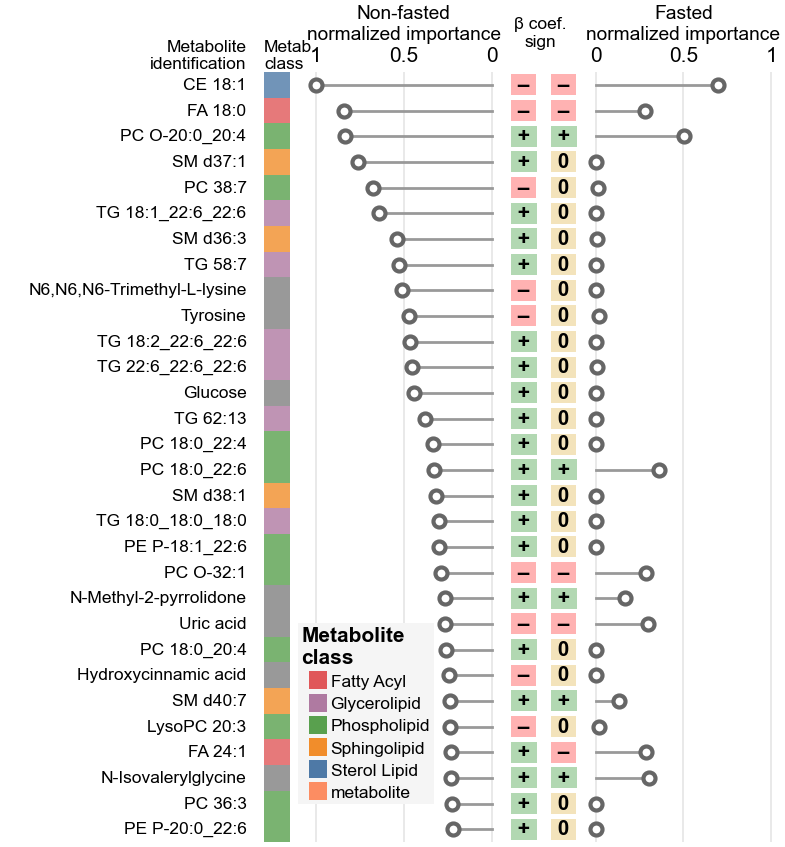

In [368]:
importlib.reload(src.plots)
fig, (axtext, axclass, axr, axrcorr, axfcorr, axf) = plt.subplots(
    ncols=6, dpi=250, figsize=(4, 4), 
    gridspec_kw=dict(width_ratios=[
        0.5,  # ID name
        0.1,  # metabolite class colorbar
        0.4,  # nonfasted bar
        0.07, # nonfasted corr
        0.07, # fasted corr
        0.4,  # nonfasted bar
    ], wspace=0.05))
axs = fig.get_axes()

# https://github.com/mwaskom/seaborn/blob/d121c9cadf835bd87bc7bd48b62e837ef165ca4d/seaborn/matrix.py
hdf['color_tuples'] = hdf['color'].apply(lambda x: tuple(x))
matrix, cmap = sns.matrix.ClusterGrid.color_list_to_matrix_and_cmap(
    colors=hdf['color_tuples'], 
    ind=hdf['y_pos'].abs(), 
    axis=0)
sns.heatmap(matrix, cmap=cmap, cbar=False, square=True, xticklabels=[], yticklabels=[], ax=axclass, alpha=0.8)

# axr.barh(y=hdf['y_pos'], width=hdf['rbg_height'])
# axf.barh(y=hdf['y_pos'], width=hdf['fbg_height'])
# axr.stem(hdf['y_pos'], hdf['rbg_height'], orientation='horizontal', bottom=2)
# axf.stem(hdf['y_pos'], hdf['fbg_height'], orientation='horizontal', bottom=-2)

for ax, name, height in ([axr, 'Non-fasted', 'rbg_height'], [axf, 'Fasted', 'fbg_height']):
    ax.scatter(hdf[height], hdf['y_pos'], color='1', s=12, lw=1.2, edgecolors='0.4', zorder=10)
    for i, row in hdf.iterrows():
        # plot stem lines
        ax.plot([0, row[height]], [row['y_pos'], row['y_pos']], zorder=5, color='0.6', linewidth=0.8)
    ax.spines.top.set_lw(0)
    ax.tick_params(length=0)
    ax.grid(axis='x', color='0.9', lw=0.5, zorder=-10)
    ax.set_axisbelow(True)
    ax.set_xlabel(f'{name}\nnormalized importance', fontsize=5.5)
    ax.xaxis.set_label_position('top')

axr.set_xticks([-1, -0.5, 0], [1, 0.5, 0])
axf.set_xticks([0, 0.5, 1], [0, 0.5, 1])
axr.set_xlim(-1.05, 0.05)
axf.set_xlim(-0.05, 1.05)

# PLOT TEXT AND CORRELATION SIGN
for i, row in hdf.iterrows():
    id_text = row['ID']
    id_text = id_text.replace('Plasmanyl-', '').replace('Plasmenyl-', '')
    axtext.text(1, row['y_pos'], id_text, fontsize=5, va='center', ha='right')
    for ax, colname, coef_colname in [(axrcorr, 'rbg_coef_sign', 'coef_rbg'),   # rbg_corr_sign rbg_coef_sign
                                      (axfcorr, 'fbg_coef_sign', 'coef_fbg')]:  # fbg_corr_sign fbg_coef_sign
        sign = row[colname]
        if sign == '+': 
            color = 'green'
            sign = ' + '
        if sign == 'ns': 
            color = 'yellow'
        if abs(row[coef_colname]) < 0.02:
            color = 'goldenrod'
            sign = ' 0 '
        if sign == '-': 
            color = 'red'
            sign = ' – '  # n-dash instead of regular dash symbol
        ax.text(0.5, row['y_pos'], sign, va='center', ha='center', fontsize=6, fontweight='bold',
                bbox=dict(color=color, pad=0.3, alpha=0.3, lw=0))
#     axtext.barh(y=row['y_pos'], width=1, facecolor=row['color'], lw=1, zorder=-1, alpha=0.1)

axrcorr.text(1, 1.03, 'β coef.\nsign', fontsize=5,  va='bottom', ha='center', transform=axrcorr.transAxes)
axclass.set_title('Metab.\nclass', loc='left', fontsize=5, pad=1)
axtext.set_title('Metabolite\nidentification', loc='right', fontsize=5, pad=1)

axtext.set_xticks([]) 
axrcorr.set_xticks([])
axfcorr.set_xticks([])
    
for ax in axs:
    ax.set_yticks([])
    ax.set_ylim(top=0.5, bottom=-1*len(hdf) + 0.5)
    sns.despine(ax=ax, left=True, top=False, bottom=True)
    
src.plots.custom_legend(
    entries=['Sterol Lipid', 'Fatty Acyl', 'Phospholipid', 'Sphingolipid', 'Glycerolipid', 'metabolite'], 
    ax=axr, loc=(-0.05, 0.05), fontsize=5, title='Metabolite\nclass', title_fontsize=6,
    show_frame=True, frame_color='0.96',
    marker='s', mew=0, ms=5, handletextpad=-0.3)
    
axclass.set_ylim(top=0, bottom=len(hdf))
sns.despine(ax=axclass, left=True, bottom=True)
sns.despine(ax=axtext, left=True, bottom=True)
sns.despine(ax=axrcorr, left=True, bottom=True)
sns.despine(ax=axfcorr, left=True, bottom=True)
# plt.savefig('../reports/figures/Figure6/Importance_fast-vs-fed_EN.pdf', bbox_inches='tight', dpi=300)

<AxesSubplot:xlabel='OGTT glucose AUC', ylabel='Log2 abundance'>

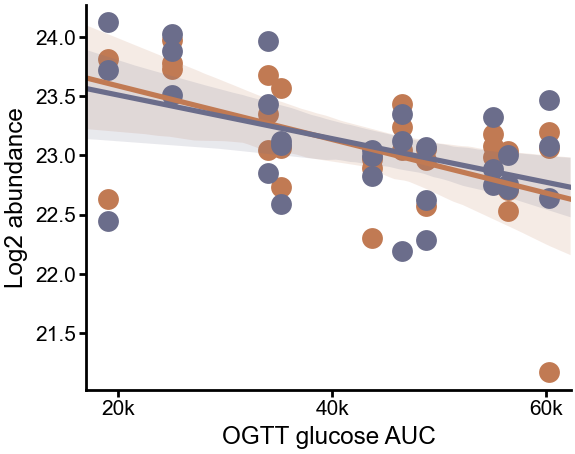

In [347]:
src.plots.plot_quant_vs_ogtt('l_844')

## Corr vs. corr plot fasted vs. fed

In [458]:
cdf = (corrdf
       .loc[(data['ID'] != 'Unidentified') & 
            ((corrdf['rbg_p'] < 0.05) | (corrdf['fbg_p'] < 0.05)) 
           ]
       .join(data[['superclass', 'molec_class', 'ID', 'Type']]))

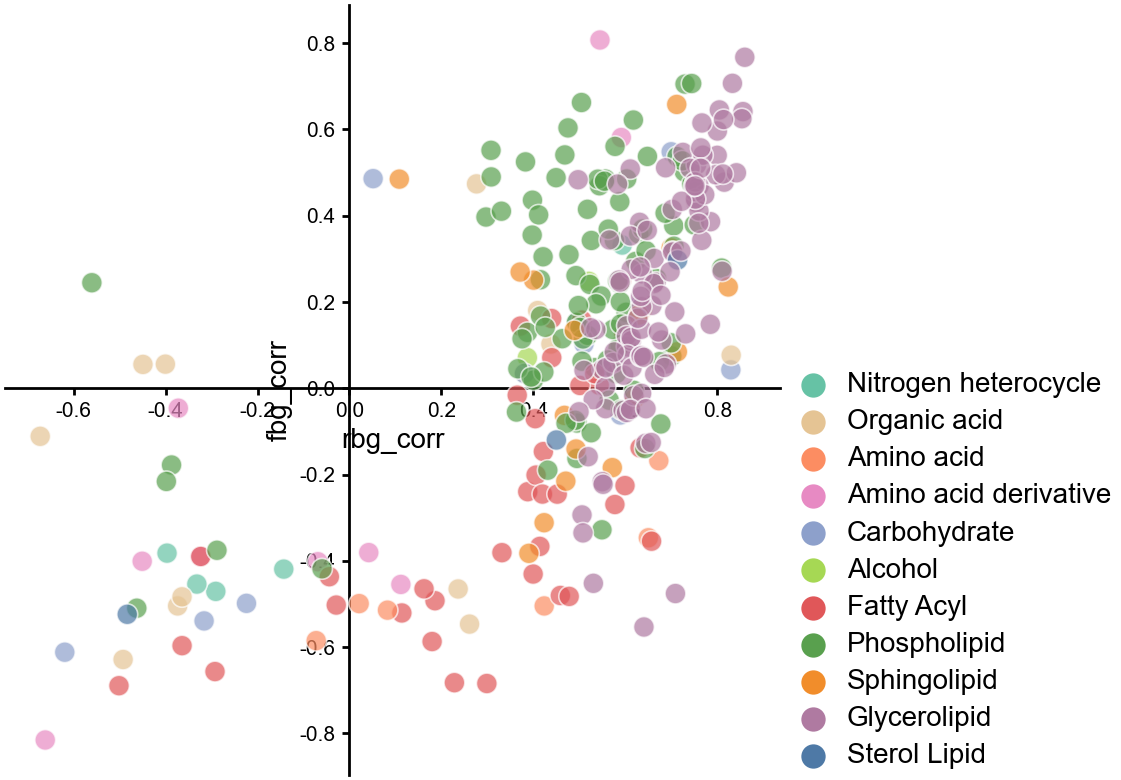

In [446]:

fig, ax = plt.subplots(dpi=250, figsize=(4,4))
sns.scatterplot(
    data=cdf, x='rbg_corr', y='fbg_corr', hue='superclass', palette=colors,
    alpha=0.7, zorder=10,
)
ax.spines.left.set_position('zero')
ax.spines.bottom.set_position('zero')
ax.set_axisbelow(True)

ax.legend(loc=(1, 0))
sns.despine()

In [454]:
cdf[['rbg_corr', 'fbg_corr']].abs().max().max()

0.8596641391476392

In [461]:
hcdf

,rbg_corr,rbg_p,fbg_corr,fbg_p,rbg_q,fbg_q,rbg_corr_signif,fbg_corr_signif,rbg_corr_sign,fbg_corr_sign,superclass,molec_class,ID,Type
i,,,,,,,,,,,,,,
l_0,-0.028754,0.880110,-0.502688,0.005450,0.917215,0.045434,False,True,ns,-,Fatty Acyl,AC,AC 5:0,lipid
l_1,-0.501352,0.004767,-0.689639,0.000035,0.012212,0.002053,True,True,-,-,Fatty Acyl,AC,AC 4:0,lipid
l_2,-0.323457,0.081231,-0.390004,0.036485,0.138565,0.149438,False,False,ns,ns,Fatty Acyl,AC,AC 3:0,lipid
l_3,-0.364120,0.047914,-0.596795,0.000632,0.089776,0.010429,False,True,ns,-,Fatty Acyl,AC,AC 2:0,lipid
l_4,0.113835,0.549201,-0.520991,0.003757,0.651916,0.035294,False,True,ns,-,Fatty Acyl,AC,AC 18:2,lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_126,0.236328,0.208638,-0.465387,0.010958,0.300277,0.064334,False,False,ns,ns,Organic acid,Organic acid,4-Hydroxybutyric acid (GHB),metabolite
m_128,0.637446,0.000152,0.182277,0.343956,0.000744,0.591018,True,False,+,ns,Organic acid,Organic acid,4-Guanidinobutyric acid,metabolite
m_135,-0.449168,0.012776,0.055279,0.775790,0.028664,0.882688,True,False,-,ns,Organic acid,Organic acid,3-Indoxyl sulphate,metabolite


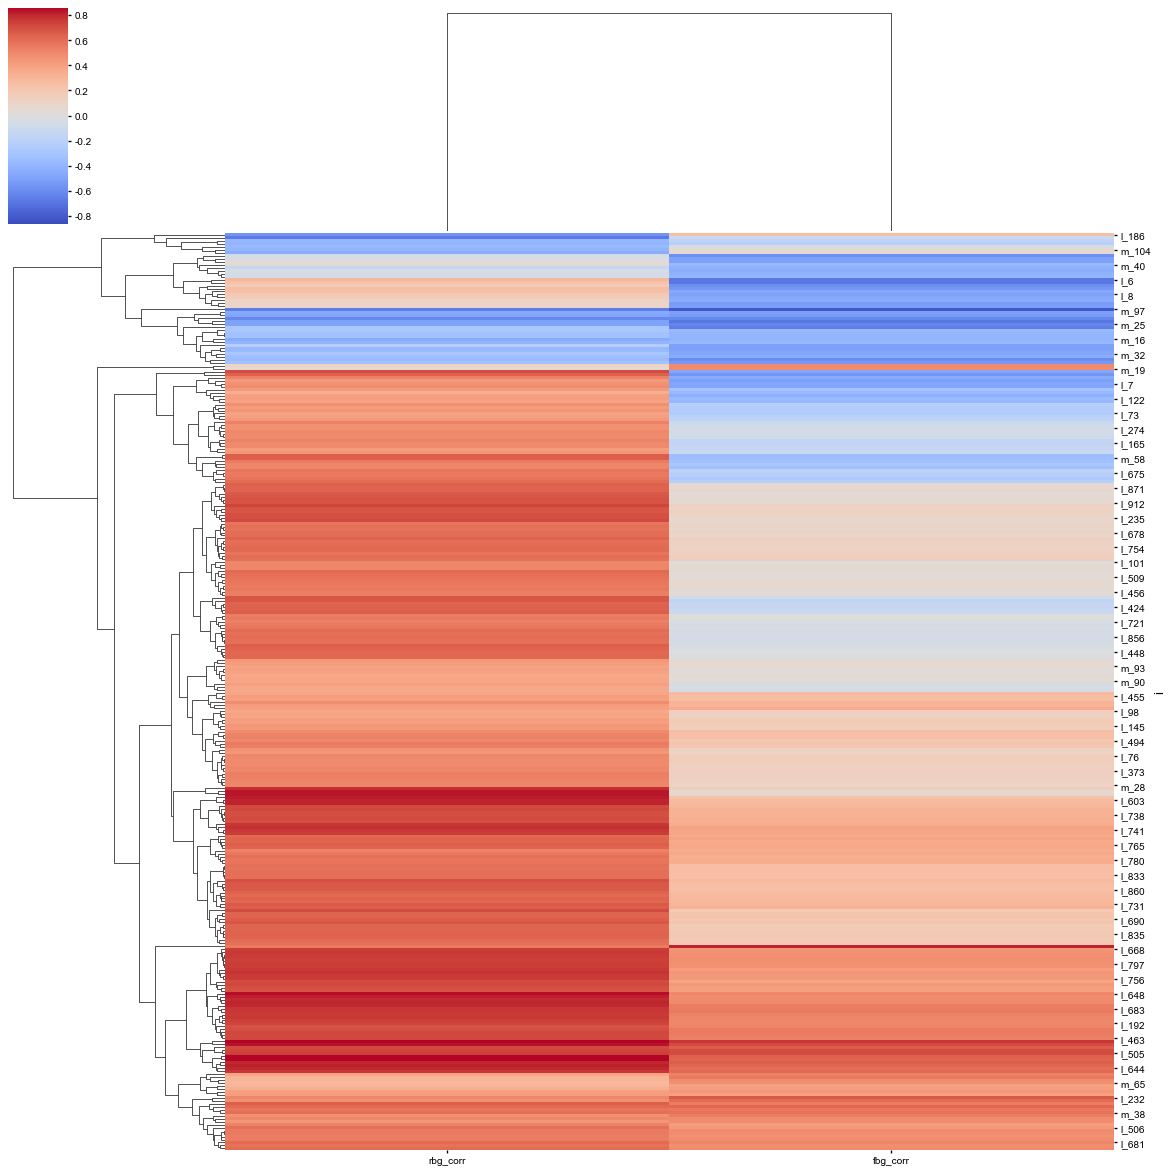

In [462]:
# fig, ax = plt.subplots(dpi=120, figsize=(2, 8))
max_corr = cdf[['rbg_corr', 'fbg_corr']].abs().max().max()
hcdf = cdf.sort_values(['Type', 'superclass'])
sns.clustermap(
    data=hcdf[['rbg_corr', 'fbg_corr']],
    vmin=-max_corr, vmax=max_corr, center=0, cmap='coolwarm',
)

# OLD CODE BELOW

## Process the model results file in one way for the boxplots

In [8]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', 
                index_col=0).rename({'x': 'Sampling'}, axis=1)
r['Sampling'] = r['Sampling'].replace('Fed', 'Non-fasted')
# r['model'] = r['model'].map({'ols': 'OLS', 'lasso': 'LASSO (L1)', 'ridge': 'Ridge (L2)', 
#                                    'svm': 'SVM\nLinear kernel', 'pls': 'PLS', 'rf': 'Random\nForest'})
mse = r.melt(value_vars=r.filter(regex='neg_mean_squared_error_\d').columns, id_vars=['model', 'Sampling', 'y']) \
        .drop('variable', axis=1)
r2 = r.melt(value_vars=r.filter(regex='r2_\d').columns, id_vars=['model', 'Sampling', 'y']) \
        .drop('variable', axis=1)
mape = r.melt(value_vars=r.filter(regex='neg_mean_absolute_percentage_error_\d').columns, 
              id_vars=['model', 'Sampling', 'y']).drop('variable', axis=1)
mae = r.melt(value_vars=r.filter(regex='neg_mean_absolute_error_\d').columns, 
              id_vars=['model', 'Sampling', 'y']).drop('variable', axis=1)
ogtt = mse.loc[mse['y'] == 'ogtt'].drop('y', axis=1)
insulin = mse.loc[mse['y'] == 'insulin'].drop('y', axis=1)
weight = mse.loc[mse['y'] == 'weight'].drop('y', axis=1)

# Examples of other plots: catplot, stripplot, boxplot, boxenplot, histplot

## Boxplot overall looks good and will be good for `r2` with its crazy low outliers 

<AxesSubplot:xlabel='value', ylabel='model'>

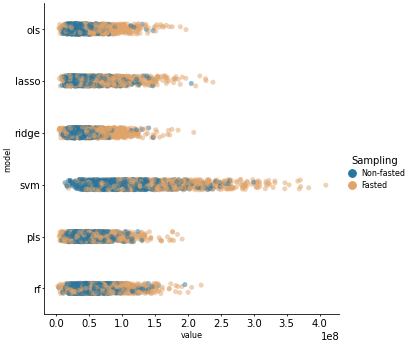

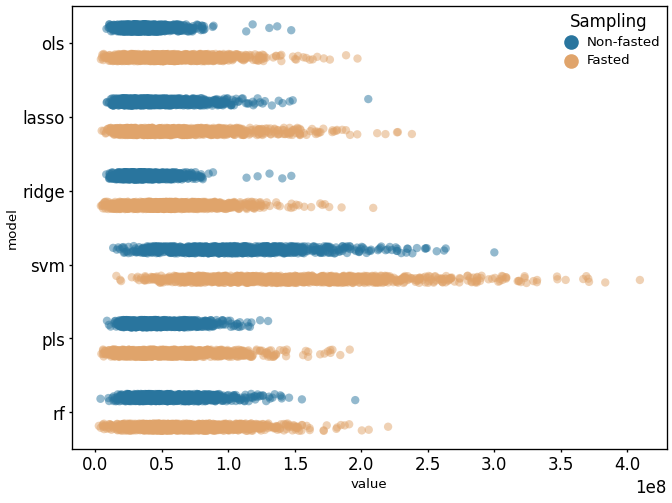

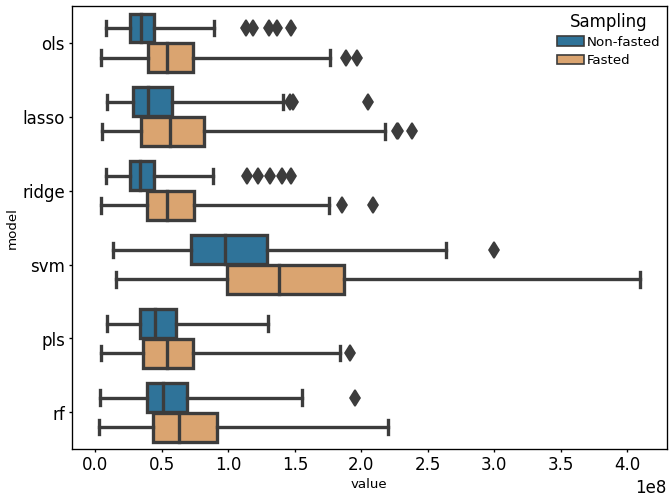

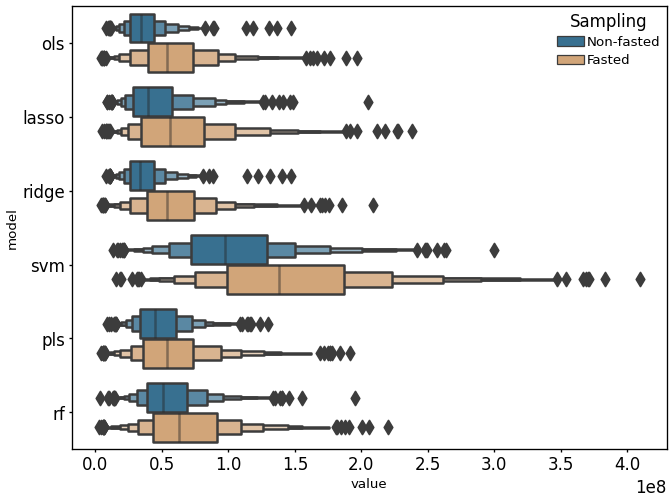

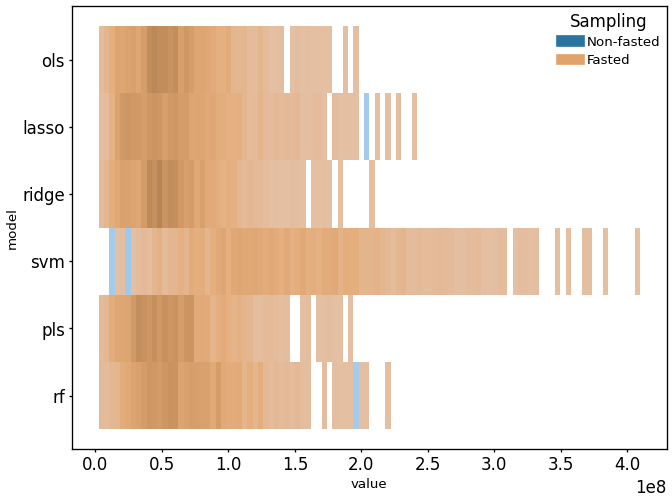

In [9]:
vp = sns.catplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
#     dodge=True,
    palette=colors, alpha=0.5,)
plt.figure()
vp = sns.stripplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
    dodge=True,
    palette=colors, alpha=0.5)
plt.figure()
vp = sns.boxplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
    width=0.8,
    linewidth=2,
    fliersize=7, whis=3,
#     scale='width',
    palette=colors, saturation=0.9,)
plt.figure()
vp = sns.boxenplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
#     scale='width',
    palette=colors, )
plt.figure()
sns.histplot(
    data=mse, x='value', y='model',
    hue='Sampling', palette=colors,)

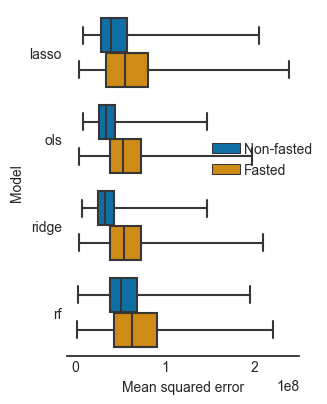

In [156]:
#### BOX PLOT VERSION ####

def plot_comparison(y, error, cut=0.4, width=0.65, whis=1.5, left=True,
                    order=['SVM\nLinear kernel', 'Random\nForest', 'PLS', 'LASSO (L1)', 'Ridge (L2)', 'OLS'],
                    annot_loc=0.35, sci_notation_format=True, round_decimal=2, split=True, ax=None,
                    loc=(0.6, 0.5),
                    **kwargs):
    df = r.loc[r['y'] == y]
    df = df.melt(value_vars=r.filter(regex=f'{error}_\d').columns, id_vars=['model', 'Sampling', 'y']) \
           .drop('variable', axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 4.5))
    p = sns.boxplot(
        data=df, x='value', y='model', hue='Sampling', ax=ax,
        orient='h', fliersize=5, whis=whis, order=order,
#         scale='width', cut=cut, width=width,
        palette=colors, saturation=0.85,  **kwargs)
    
    for i, model in enumerate(r['model'].unique()):
        for bg_type, direction in [('Fasted', 1), ('Non-fasted', -1)]:
            error_median = r.loc[(r['model'] == model) & (r['Sampling'] == bg_type) & (r['y'] == y), 
                             f'{error}_median'].iloc[0]
            x_point = ax.get_xlim()[1] * annot_loc
            if sci_notation_format:
                error_median = f"{Decimal(error_median):.1e}".replace('+', '')
            else:
                error_median = round(error_median, round_decimal)
#             ax.annotate(error_median, xy=(annot_loc, i*(1/6)+direction*0.02), 
#                          ha='center', va='center', fontsize=14, xycoords='figure fraction')
#             ax.annotate(error_median, xy=(, i + direction*0.2), 
#                          ha='center', va='center', fontsize=14, xycoords='figure fraction')
#     plt.yticks(fontsize=14)
    ax.set_ylabel('Model', fontsize=10)
#     plt.xticks(fontsize=14)
    xlabel = error.lstrip('neg_').replace('_', ' ').capitalize()
    if xlabel == 'R2':
        xlabel = '$r^2$'
    ax.set_xlabel(xlabel, fontsize=10)
#     for y in np.arange(0.5, 5, 1):
#         plt.axhline(y=y, color='gray')
    ax.tick_params(axis='both', length=0)
#     plt.grid(axis='x', visible=None, ) 
    ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
    ax.legend(loc=loc, markerscale=3, fontsize=10, frameon=False, ncol=1, handletextpad=0.3)
    sns.despine(left=left)
    
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True,
                order=['lasso', 'ols', 'ridge', 'rf'],
                error='neg_mean_squared_error',) # r2 neg_mean_absolute_percentage_error neg_mean_squared_error
                                                 
# plt.savefig(r'../reports/figures/fig6_model_feat_imp_plots/mse_boxplot.png', bbox_inches='tight', dpi=150)
# plt.savefig(r'../reports/figures/fig6_model_feat_imp_plots/mse_boxplot.pdf', bbox_inches='tight', dpi=150)

In [291]:
# plot_comparison(y='ogtt', split=False, annot_loc=0.5, left=False, showfliers=False, whis=1.5,
#                 error='r2')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/r2_boxplot.png', bbox_inches='tight', dpi=100)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/r2_boxplot.pdf', bbox_inches='tight', dpi=100)

## Process model results file in another way for the feature importance plots

In [6]:
rdf = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', index_col=0)
rdf = rdf.loc[(rdf['y'] == 'ogtt') & 
              (rdf['model'].isin(['ols', 'lasso', 'pls', 'rf', 'svm', 'ridge']))].drop('y', axis=1)
cols = ['model', 'x']
cols.extend(data.index)
rdf = rdf[cols]
rdf['i'] = rdf['model'] + '_' + rdf['x']
new_cols = rdf['i']
rdf = rdf.drop(['model', 'x'], axis=1)
rdf = rdf.set_index('i').T.abs()
# rdf = rdf.loc[data['ID'] != 'unknown']  # only use IDs
# rdf = rdf.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')]
rdf.loc[:, :] = MinMaxScaler().fit_transform(rdf)  # perform 0 to 1 scaling of absolute value of coefficients
rdf = rdf.join(data)
rdf = rdf.sort_values('ols_Fed', ascending=False)  # .iloc[:20]
rdf['y_point'] = range(len(rdf))  # range(len(r), 0, -1)
rdf['is_id'] = rdf['ID'] != 'Unidentified'
rdf['avg_Fed'] = rdf.filter(regex='_Fed').mean(axis=1)
rdf['avg_Fasted'] = rdf.filter(regex='_Fasted').mean(axis=1)
rdf['Molecule class'] = rdf['superclass'].map(colors)
rdf['Molecule type'] = rdf['Type'].map(colors)
# rdf

## Using the normalized feature coefficients from the best performing model (Fed, linear regression), create a loadings plot of the features, colored by molec_class

In [255]:
odf = rdf[['ols_Fed']]
odf = odf.join(data[['ID', 'molec_class', 'superclass', 'Type']])
odf = odf.loc[odf['ID'] != 'Unidentified']

# re-normalize (because an Unidentified feature had the highest coefficient)
odf['ols_Fed'] = odf['ols_Fed'] / odf['ols_Fed'].max()
odf['i'] = odf.index
odf['color'] = odf['superclass'].map(colors)
mdf = odf.loc[odf['Type'] == 'metabolite']
odf = odf.loc[odf['Type'] == 'lipid']
# odf = odf.iloc[:100]
odf['rank'] = odf['ols_Fed'].rank(ascending=False)
odf

,ols_Fed,ID,molec_class,superclass,Type,i,color,rank
l_134,1.000000,FA 18:0,FA,Fatty Acyl,lipid,l_134,"[0.8392156862745098, 0.15294117647058825, 0.15...",1.0
l_435,0.908246,SM d37:1,SM,Sphingolipid,lipid,l_435,"[1.0, 0.4980392156862745, 0.054901960784313725]",2.0
l_844,0.858891,CE 18:1,CE,Sterol Lipid,lipid,l_844,"[0.12156862745098039, 0.4666666666666667, 0.70...",3.0
l_186,0.818057,PC 38:7,PC,Phospholipid,lipid,l_186,"[0.17254901960784313, 0.6274509803921569, 0.17...",4.0
l_505,0.817185,Plasmanyl-PC O-20:0_20:4,Plasmanyl-PC,Phospholipid,lipid,l_505,"[0.17254901960784313, 0.6274509803921569, 0.17...",5.0
...,...,...,...,...,...,...,...,...
l_173,0.007403,PI 18:2_18:1,PI,Phospholipid,lipid,l_173,"[0.17254901960784313, 0.6274509803921569, 0.17...",356.0
l_555,0.002729,Cer[NS] d18:1_24:1,Cer[NS],Sphingolipid,lipid,l_555,"[1.0, 0.4980392156862745, 0.054901960784313725]",357.0
l_576,0.001966,Cer[NS] d41:1,Cer[NS],Sphingolipid,lipid,l_576,"[1.0, 0.4980392156862745, 0.054901960784313725]",358.0
l_122,0.001670,FA 20:2,FA,Fatty Acyl,lipid,l_122,"[0.8392156862745098, 0.15294117647058825, 0.15...",359.0


In [261]:
# plt.hist(odf.loc[odf['molec_class'] == 'TG', 'rank'], bins=20)
# plt.figure()
# plt.hist(odf.loc[odf['superclass'] == 'Phospholipid', 'rank'], bins=20)

# The lipid "loadings" plot is surprisingly uniform in the distribution of Phospholipids vs TGs 

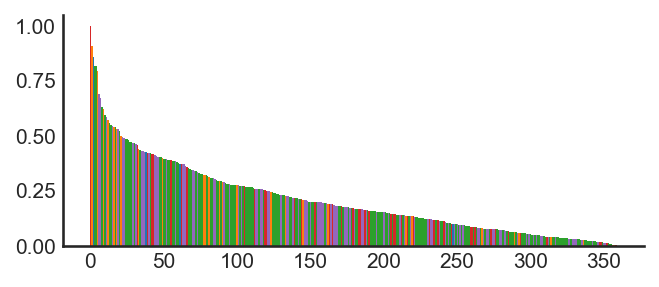

In [252]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 2))
plt.bar(range(len(odf)), odf['ols_Fed'], color=odf['color'], edgecolor='none',
        width=1)
sns.despine()

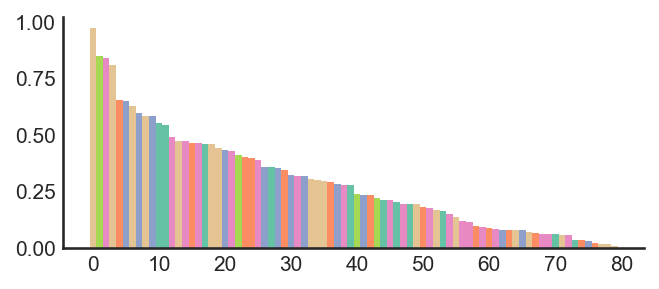

In [253]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 2))
plt.bar(range(len(mdf)), mdf['ols_Fed'], color=mdf['color'], edgecolor='none',
        width=1)
sns.despine()

## Vertical orientation heatmap

In [38]:
data.loc[data['ID'].str.contains('22:6_22:6')]

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,lipid_class,extra_lipid_label,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks
i,,,,,,,,,,,,,,,,,,,,,
l_569,TG 20:5_22:6_22:6_13.093_1014.755,TG 20:5_22:6_22:6,1014.75500,13.093,TG,lipid,+,RP,Glycerolipid,21.646018,...,21.746716,8.299210,3.393655,True,TG,NaN,64.0,17.0,64:17,***
l_582,TG 22:6_22:6_22:6_13.389_1040.7701,TG 22:6_22:6_22:6,1040.77014,13.389,TG,lipid,+,RP,Glycerolipid,20.194712,...,16.552043,12.085825,3.345257,True,TG,NaN,66.0,18.0,66:18,***
l_611,TG 18:2_22:6_22:6_14.115_997.7252,TG 18:2_22:6_22:6,997.72522,14.115,TG,lipid,+,RP,Glycerolipid,22.986681,...,12.528394,10.835321,3.444618,True,TG,NaN,62.0,14.0,62:14,***
l_648,TG 18:1_22:6_22:6_14.916_999.7401,TG 18:1_22:6_22:6,999.74011,14.916,TG,lipid,+,RP,Glycerolipid,22.408130,...,6.022581,8.799834,2.677907,True,TG,NaN,62.0,13.0,62:13,**
l_652,TG 16:0_22:6_22:6_14.93_973.725,TG 16:0_22:6_22:6,973.72504,14.930,TG,lipid,+,RP,Glycerolipid,23.106797,...,18.633607,8.849089,2.814134,True,TG,NaN,60.0,12.0,60:12,**


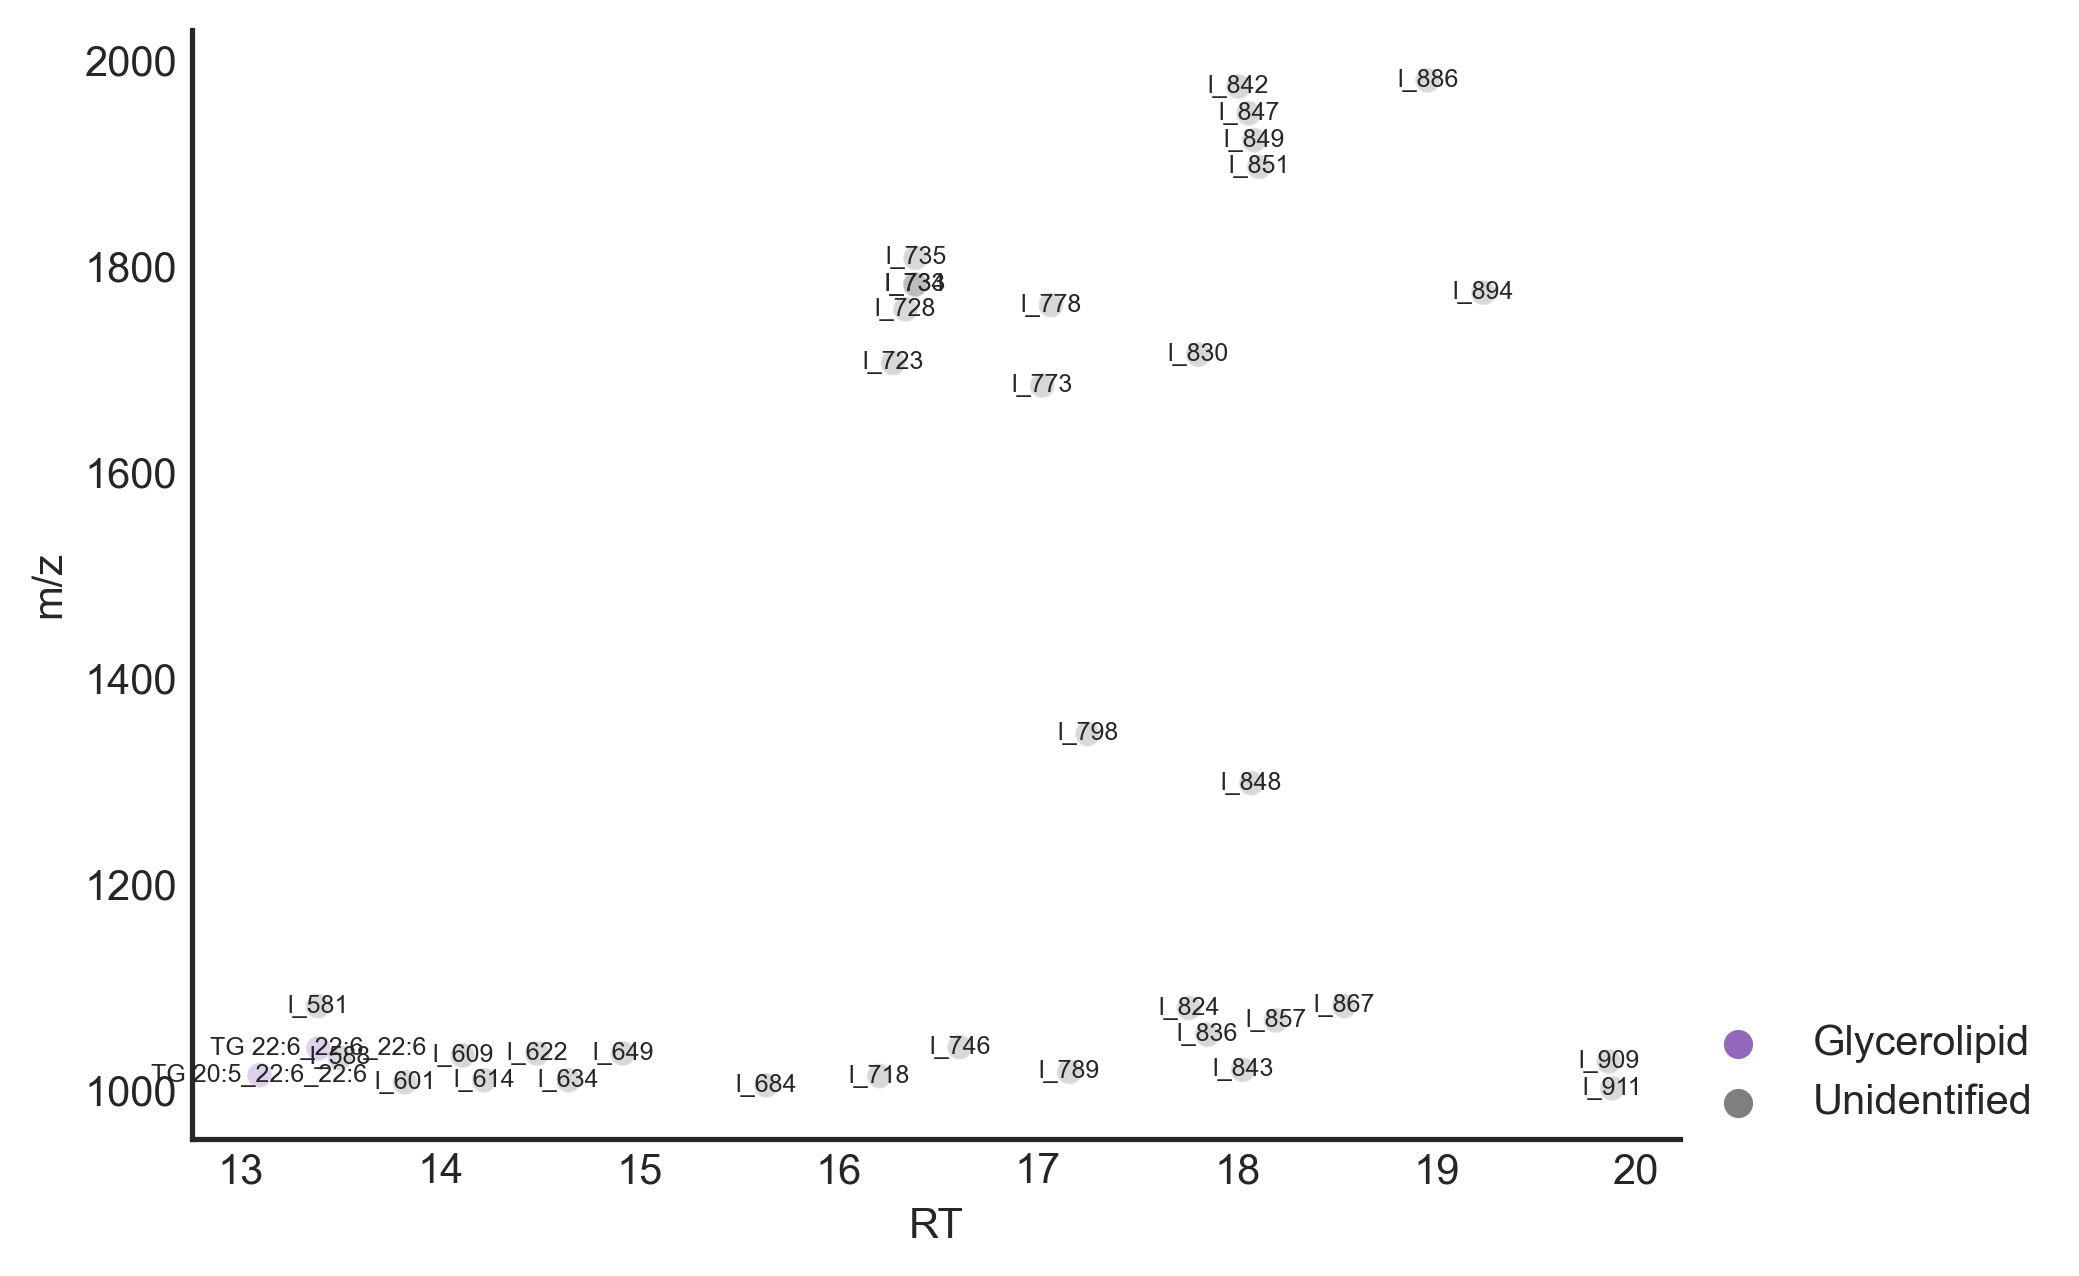

In [61]:
plotdf = data.loc[(data['RT'] > 13) & (data['m/z'] > 1000)]
fig, ax = plt.subplots(dpi=300)
sns.scatterplot(
    data=plotdf, ax=ax,
    x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.3,
)
for i, row in plotdf.iterrows():
    if row['ID'] == 'Unidentified':
        text = i
    else:
        text = row['ID']
    ax.annotate(text=text, xy=(row['RT'], row['m/z']), ha='center', va='center', fontsize=6)
plt.legend(loc=(1, 0))
sns.despine()

<AxesSubplot:xlabel='ogtt', ylabel='quant'>

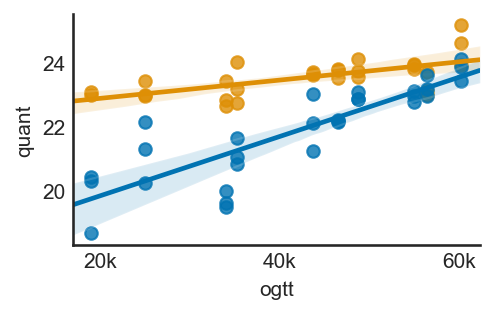

In [112]:
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=150)
plot_quant_vs_ogtt('l_611', ax=ax)

In [67]:
rdf.sort_values('avg_Fed', ascending=False).loc[:, ['avg_Fed', 'ID', 'm/z', 'RT', 'polarity']].iloc[:30]

,avg_Fed,ID,m/z,RT,polarity
l_851,0.796973,Unidentified,1896.74500,18.110,+
l_435,0.756320,SM d37:1,745.62457,9.972,+
m_206,0.648419,Unidentified,223.08152,9.053,-
l_842,0.600881,Unidentified,1974.79395,18.006,+
l_581,0.591890,Unidentified,1081.79688,13.387,+
m_168,0.575684,Unidentified,174.00102,9.940,-
m_425,0.572947,Unidentified,261.21722,7.348,+
l_610,0.568701,Unidentified,994.77686,14.113,+
l_812,0.566652,Unidentified,383.36713,17.480,+
l_505,0.564724,Plasmanyl-PC O-20:0_20:4,824.65430,11.065,+


In [120]:
indexes = set()
for model in ['ols', 'pls', 'rf']:
    topdf = (rdf
             .loc[(data['ID'] != 'Unidentified') & (data['Type'])]
             .drop(['m_104', 'm_135'])
             .sort_values(by=f'{model}_Fed', ascending=False)
             
             .iloc[:10])
    display(topdf[[f'{model}_Fed', 'ID']])
    for i in topdf.index:
        indexes.add(i)
len(indexes)

,ols_Fed,ID
l_134,0.860758,FA 18:0
l_435,0.781780,SM d37:1
l_844,0.739298,CE 18:1
m_127,0.731062,4-Hydroxybenzaldehyde
m_34,0.720720,"N6,N6,N6-Trimethyl-L-lysine"
l_186,0.704149,PC 38:7
l_505,0.703398,Plasmanyl-PC O-20:0_20:4
l_195,0.682813,SM d36:3
l_794,0.591683,TG 58:7
l_648,0.578757,TG 18:1_22:6_22:6


,pls_Fed,ID
l_844,0.959198,CE 18:1
m_95,0.888387,Carnitine
l_435,0.849229,SM d37:1
l_186,0.794146,PC 38:7
l_195,0.764691,SM d36:3
l_496,0.758458,Plasmenyl-PE P-20:0_22:6
m_66,0.740813,Iditol
l_166,0.739526,SM d40:7
l_648,0.717220,TG 18:1_22:6_22:6
l_582,0.714897,TG 22:6_22:6_22:6


,rf_Fed,ID
l_648,0.258309,TG 18:1_22:6_22:6
l_569,0.254778,TG 20:5_22:6_22:6
l_663,0.254166,TG 16:0_22:6_22:5
l_582,0.243338,TG 22:6_22:6_22:6
l_623,0.243201,TG 62:13
l_123,0.215973,FA 24:5
l_435,0.214639,SM d37:1
l_330,0.200463,PC 39:4
l_632,0.175693,TG 18:1_20:5_22:6
l_611,0.168411,TG 18:2_22:6_22:6


22

In [118]:
data.loc[indexes]

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,lipid_class,extra_lipid_label,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks
i,,,,,,,,,,,,,,,,,,,,,
m_95,Carnitine_10.537_162.1125,Carnitine,162.11253,10.537,Organic acid,metabolite,+,HILIC,Organic acid,24.129270,...,9.472328,1.962113,0.766343,True,NaN,NaN,NaN,NaN,NaN,ns
m_66,Iditol_10.884_181.0709,Iditol,181.07085,10.884,Carbohydrate,metabolite,-,HILIC,Carbohydrate,18.505919,...,10.191258,5.959159,0.635923,True,NaN,NaN,NaN,NaN,NaN,ns
l_623,TG 62:13_14.489_994.7858,TG 62:13,994.78577,14.489,TG,lipid,+,RP,Glycerolipid,20.898315,...,4.193504,10.400380,2.456891,True,TG,NaN,62.0,13.0,62:13,**
l_134,FA 18:0_6.533_283.2645,FA 18:0,283.26453,6.533,FA,lipid,-,RP,Fatty Acyl,27.100050,...,0.073621,0.837478,0.560689,True,FA,NaN,18.0,0.0,18:0,ns
l_166,SM d40:7_7.648_775.5759,SM d40:7,775.57587,7.648,SM,lipid,+,RP,Sphingolipid,19.443669,...,10.196544,7.096470,0.159648,True,SM,40:7d,40.0,7.0,40:7,ns
l_435,SM d37:1_9.972_745.6246,SM d37:1,745.62457,9.972,SM,lipid,+,RP,Sphingolipid,20.611215,...,0.384042,5.476477,2.107856,True,SM,37:1d,37.0,1.0,37:1,**
m_135,3-Indoxyl sulphate_8.177_212.0014,3-Indoxyl sulphate,212.00143,8.177,Organic acid,metabolite,-,HILIC,Organic acid,20.507605,...,1.286151,0.840874,0.921479,True,NaN,NaN,NaN,NaN,NaN,ns
l_569,TG 20:5_22:6_22:6_13.093_1014.755,TG 20:5_22:6_22:6,1014.75500,13.093,TG,lipid,+,RP,Glycerolipid,21.646018,...,21.746716,8.299210,3.393655,True,TG,NaN,64.0,17.0,64:17,***
l_632,TG 18:1_20:5_22:6_14.643_968.7708,TG 18:1_20:5_22:6,968.77075,14.643,TG,lipid,+,RP,Glycerolipid,24.679097,...,13.388389,6.128974,3.482515,True,TG,NaN,60.0,12.0,60:12,***


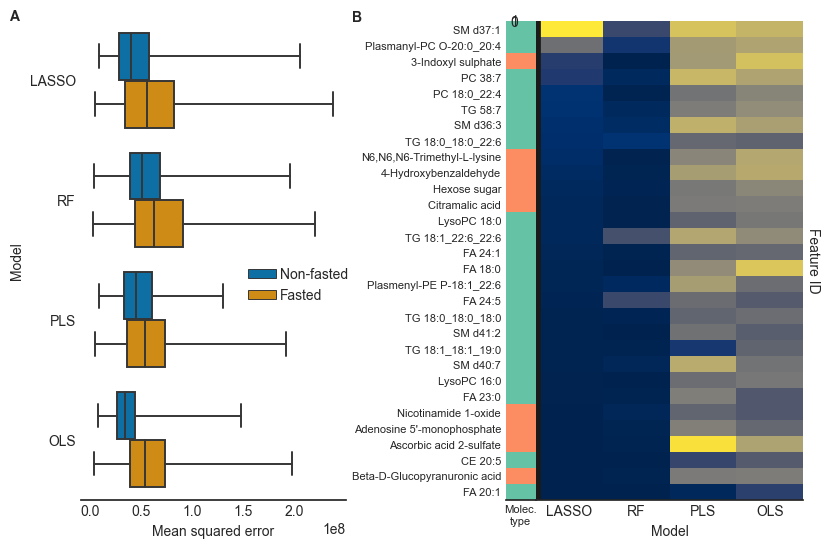

In [139]:
# fig, ax = plt.subplots(figsize=(3, 6), dpi=120)
Type = 'Fed'
models = [
    'lasso', 
    'rf',
    'pls', 
    'ols'
]
model_names = [model.upper() for model in models]
hmdf = (rdf
 .loc[
     (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:30]
)

cm = sns.clustermap(
    hmdf, cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False, row_colors=rdf.loc[hmdf.index, 'Molecule type'],
    colors_ratio=0.1, dendrogram_ratio=0.001, figsize=(8, 6), vmin=0, vmax=1,
#     cbar_pos=None,
    cbar_pos=(2, 0.4, 0.08, 0.4),  # (left, bottom, width, height)
#     cbar_kws={'aspect': 10},
)
hm = cm.ax_heatmap
rc = cm.ax_row_colors
cb = cm.ax_cbar

rc.set_yticks(ticks=np.arange(0.5, len(hmdf)+0.5, 1), labels=rdf.loc[hmdf.index, 'ID'], fontsize=8)
rc.set_xticklabels(labels=['Molec.\ntype'], fontsize=8, rotation=0)
hm.set_xlabel('Model')
hm.set_ylabel('Feature ID\n', rotation=270, labelpad=12)
hm.yaxis.set_label_position('right')
hm.set_yticks([])
# hm.tick_params(size=0, axis='x', pad=0.5)
hm.set_xticklabels(model_names, rotation=0)
hm.axvline(0, color='0.1', linewidth=7,)
# cb.set_title('Relative\nfeature\nimportance')

# labels = ['Lipid', 'Polar metabolite']
# handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
#            Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
# legend2 = plt.legend(handles, labels, title='Molecule type', 
#            bbox_to_anchor=(0.85, 0.2), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
# cm.fig.add_artist(legend2)

# Add models plot  # https://stackoverflow.com/questions/51811972/adding-seaborn-clustermap-to-figure-with-other-plots
cm.gs.update(left=0.55)
gs2 = plt.GridSpec(1, 1, right=0.35)
# gs3 = plt.GridSpec(1, 1, left=0.96)
ax2 = cm.fig.add_subplot(gs2[0])
# cax = cm.fig.add_subplot(gs3[0])
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True, ax=ax2,
                order=models, loc=(0.61, 0.4), error='neg_mean_squared_error',)
ax2.set_yticklabels([model.upper() for model in models])
for ax, letter in zip([ax2, rc], ['A', 'B']):
        bb = tight_bbox(ax)
        ax.text(x=bb.x0, y=bb.y1, s=letter, transform=cm.fig.transFigure, fontweight='bold')
# print(rdf.loc[hmdf.index, 'ID'].value_counts())
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/combined.pdf', dpi=150, bbox_inches='tight', facecolor='white')
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/combined.png', dpi=150, bbox_inches='tight', facecolor='white')

''

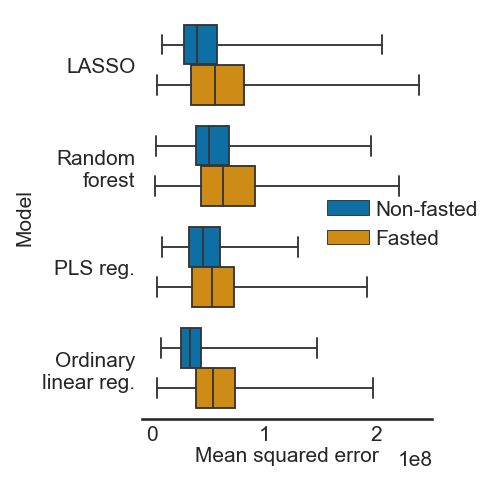

In [164]:
fig, ax = plt.subplots(figsize=(2.5, 3.5), dpi=150)
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True, ax=ax,
                order=models, loc=(0.61, 0.4), error='neg_mean_squared_error',
                linewidth=0.9)
ax.set_yticks([0,1,2,3], ['LASSO', 'Random\nforest', 'PLS reg.', 'Ordinary\nlinear reg.'])
ax.tick_params(pad=3)
ax.set_xlabel('Mean squared error', labelpad=1)
;

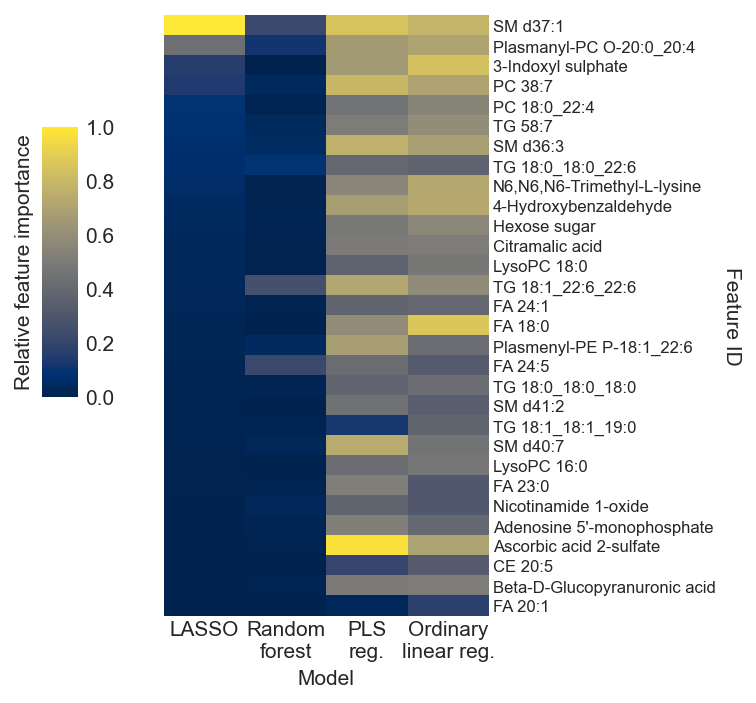

In [216]:
Type = 'Fed'
models = [
    'lasso', 
    'rf',
    'pls', 
    'ols'
]
model_names = [model.upper() for model in models]
long_model_names = ['LASSO', 'Random\nforest', 'PLS\nreg.', 'Ordinary\nlinear reg.']
hmdf = (rdf
 .loc[
     (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:30]
)

cm = sns.clustermap(
    hmdf, cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False, 
#     row_colors=rdf.loc[hmdf.index, 'Molecule type'], colors_ratio=0.1,
    dendrogram_ratio=0.001, figsize=(3, 4.5), vmin=0, vmax=1,
#     cbar_pos=None,
    cbar_pos=(-0.2, 0.4, 0.08, 0.4),  # (left, bottom, width, height)
#     cbar_kws={'label': 'hi'},
)
fig = cm.fig
hm = cm.ax_heatmap
cb = cm.ax_cbar
cb.yaxis.set_label_position('left')
cb.set_ylabel('Relative feature importance')
hm.set_yticks(ticks=np.arange(0.5, len(hmdf)+0.5, 1), labels=rdf.loc[hmdf.index, 'ID'], fontsize=8)
hm.tick_params(pad=2)
hm.set_xlabel('Model')
hm.set_ylabel('Feature ID\n', rotation=270, labelpad=12)
hm.yaxis.set_label_position('right')
hm.set_xticklabels(long_model_names, rotation=0)
fig.set_dpi(150)

In [223]:
def plot_importance(df, Type, sampling, is_id=True, num_features=20, 
                    model_ranking='ols', models=['ols', 'lasso', 'pls', 'rf'],
                    stem=False):
    """
    Type = 'lipid', 'metabolite' or '' empty string to get all 
    sampling = 'Fed' or 'Fasted'
    is_id = True for only IDs, False for only un-IDs, 
    """
    df = (df.loc[(df['is_id'] == is_id) & (df['Type'].str.contains(Type))] 
          .sort_values(f'{model_ranking}_{sampling}', ascending=False) 
          .iloc[:num_features] 
          .melt(id_vars=['ID'], value_vars=[model+'_'+sampling for model in models]) 
         )
    fig, ax = plt.subplots(figsize=(4, 1.6 + 0.4*num_features), dpi=80)
    bp = sns.barplot(
        data=df, x='value', y='ID', orient='horizontal', hue='variable',
        palette=sns.color_palette('cubehelix', len(models)),  # 'Set2' 'cubehelix', 'hls', 'husl', 'Dark2', 'brg'
        edgecolor='0.2', alpha=1, saturation=0.9, ci=None, dodge=True, ax=ax,
    )
    for patch in bp.patches:  # Set bar width, because the 'width' parameter in sns.barplot is broken 
        if stem:
            patch.set_height(0.08)
            patch.set_linewidth(0)
            bb = patch.get_bbox()
            ax.scatter([bb.x1], [bb.y1-0.05], color=patch.get_facecolor(), s=55)
        if not stem:
            patch.set_height(0.16)
        
    plt.yticks(fontsize=15)
    plt.ylabel('Identification', fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel('Scaled feature importance', fontsize=15)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=[x.upper() for x in models], 
               title='Model', title_fontsize=16, 
               loc=(1.01, 0.3), fontsize=14, markerscale=2)
    # plt.axvline(1, c='gray', alpha=0.7)
#     plt.grid(axis='x', visible=None)
#     for y_pos in np.arange(ax.get_ylim()[1], ax.get_ylim()[0], len(df)):
#         ax.axhspan(y_pos)
    sns.despine(left=True)
    return bp

(9.5, -1.0)

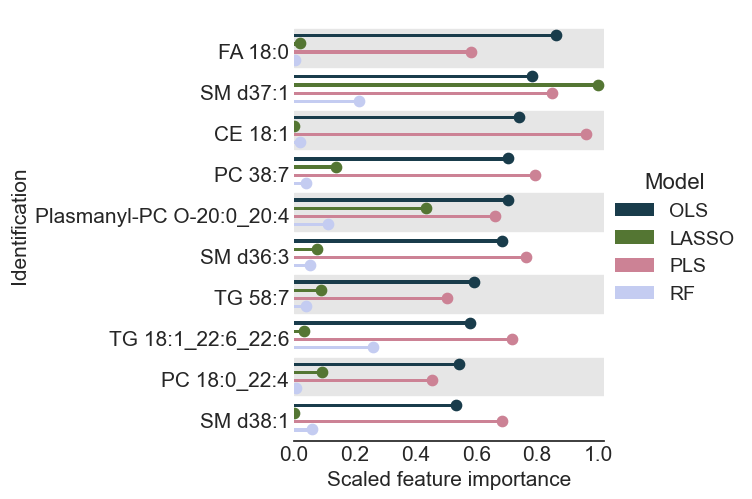

In [224]:
bp = plot_importance(df=rdf, Type='lipid', is_id=True, sampling='Fed', 
                     num_features=10, model_ranking='ols', stem=True)
fig = plt.gcf()
ax = plt.gca()
fig.set_facecolor('white')
fig.set_dpi(100)

for y_loc in ax.get_yticks()[::2]:
#     if y_loc % 2 == 1:
    ax.axhspan(ymin=y_loc-0.52, ymax=y_loc+0.4, color='0.9', zorder=-100)
ax.set_xlim(0, 1.02)
ax.set_ylim(9.5, -1)

## Horizontal heatmap orientation

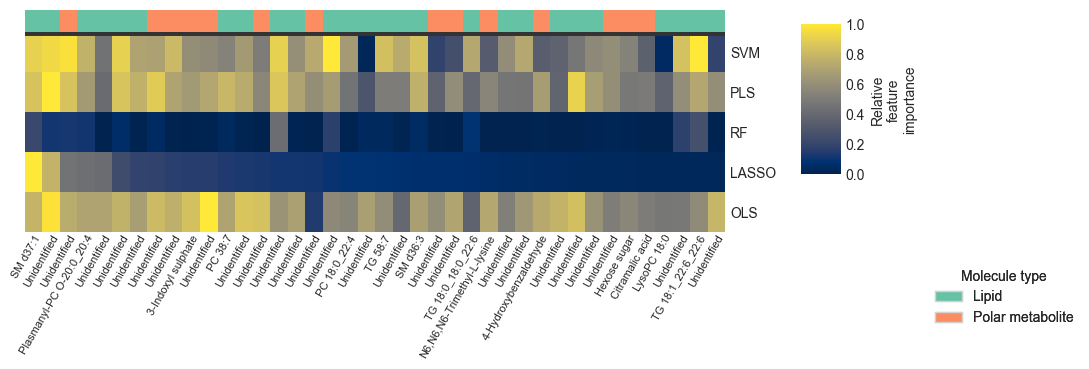

In [313]:
# fig, ax = plt.subplots(figsize=(3, 6), dpi=120)
Type = 'Fed'
models =      [ 'svm','pls', 'rf', 'lasso',  'ols',]
model_names = [ 'SVM','PLS', 'RF', 'LASSO',  'OLS',]
hmdf = (rdf
 .loc[:
#      (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:40]
)

cm = sns.clustermap(
    hmdf.T, 
    cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False,
    col_colors=(
        rdf.loc[hmdf.index, 'Molecule type'], 
#         rdf.loc[hmdf.index, 'Molecule class']
    ),
    colors_ratio=0.1, dendrogram_ratio=0.001,
    figsize=(8, 3),
    cbar_pos=(0.99, 0.4, 0.05, 0.5),  # (left, bottom, width, height)
    cbar_kws={'label': 'Relative\nfeature\nimportance'},
    vmin=0, vmax=1,
#     xticklabels=False,
#     legend=True,
)
hm = cm.ax_heatmap
hm.set_xticks(ticks=np.arange(1, len(hmdf)+1, 1), labels=rdf.loc[hmdf.index, 'ID'], 
              fontsize=8, rotation=60, ha='right', va='top');
hm.tick_params(size=0, axis='x', pad=0.5)
hm.set_yticklabels(model_names)
hm.axhline(0, color='0.2', linewidth=5,)
# cm.ax_col_colors.set_yticks([0.5, 1.5], ['Molecule type', 'Molecule class'])
cm.ax_col_colors.yaxis.tick_right()

# ADD LEGENDS TO PLOT
# handles, labels = [], []
# for superclass in rdf.loc[hmdf.index].sort_values('Type').loc[:, 'superclass'].unique():
#     s_color = colors[superclass]
#     labels.append(superclass)
#     handles.append(Patch(edgecolor='lightgray', facecolor=s_color))
# legend1 = plt.legend(handles, labels, title='Molecule class',
#            bbox_to_anchor=(1.2, 0.1), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
# cm.fig.add_artist(legend1)

labels = ['Lipid', 'Polar metabolite']
handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
           Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
legend2 = plt.legend(handles, labels, title='Molecule type', 
           bbox_to_anchor=(1.15, -0.12), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend2)

# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/Nonfasted_heatmap.pdf', dpi=150, bbox_inches='tight')
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/Nonfasted_heatmap.png', dpi=150, bbox_inches='tight')

In [ ]:
plt.colorbar

In [233]:
sns.heatmap

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

# Older versions below

(0.0, 1.0)

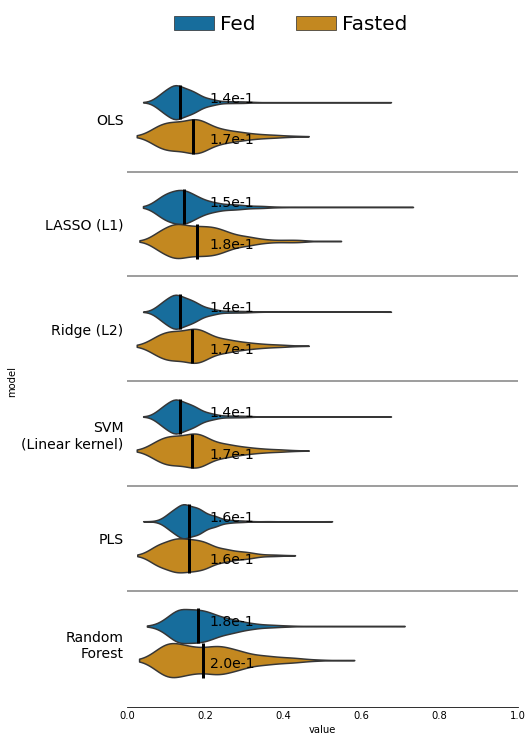

In [235]:
#### VIOLIN PLOT VERSION ####

def plot_comparison(y, error, cut=0.4, width=0.65, 
                    annot_loc=0.35, sci_notation_format=True, round_decimal=2, split=True, 
                    **kwargs):
    df = r.loc[r['y'] == y]
    df = df.melt(value_vars=r.filter(regex=f'{error}_\d').columns, id_vars=['model', 'Feeding', 'y']) \
           .drop('variable', axis=1)
    fig, ax = plt.subplots(figsize=(7, 12))
    vp = sns.violinplot(
        data=df, x='value', y='model',
        orient='h', split=split, hue='Feeding', 
        scale='width', cut=cut, width=width,
        palette=colors, inner=None, ax=ax, **kwargs)
    for i, model in enumerate(r['model'].unique()):
        for bg_type, direction in [('Fasted', 1), ('Fed', -1)]:
            error_median = r.loc[(r['model'] == model) & (r['Feeding'] == bg_type) & (r['y'] == y), 
                             f'{error}_median'].iloc[0]
            ax.plot([error_median, error_median], [i, i + direction*0.33], linewidth=3, color='black', solid_capstyle='butt')
            x_point = ax.get_xlim()[1] * annot_loc
            if sci_notation_format:
                error_median = f"{Decimal(error_median):.1e}".replace('+', '')
            else:
                error_median = round(error_median, round_decimal)
            ax.annotate(error_median, xy=(x_point, i + direction*0.2), 
                         ha='center', va='center', fontsize=14)
    plt.yticks(fontsize=14)
#     plt.xlim(plt.xlim()[0], plt.xlim()[1]*0.8)
    for y in np.arange(0.5, 5, 1):
        plt.axhline(y=y, color='gray')
    plt.tick_params(axis='both', length=0)
    # plt.grid(axis='x', visible=None, ) 
    # ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
    plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
    sns.despine(left=True)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)
plot_comparison(y='ogtt', error='neg_mean_absolute_percentage_error', split=False)
plt.xlim(0, 1)

## It's difficult to get the `r2` plot to look OK with violin plot because it goes from -10 to 1.0
## Better would be box plot with no fliers

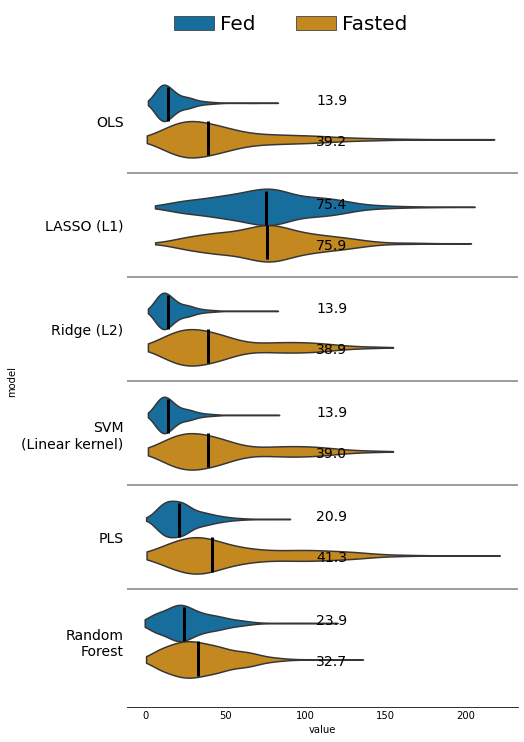

In [241]:
plot_comparison(y='weight', error='neg_mean_squared_error',
                width=0.7, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=False, round_decimal=1,
                split=False)
# plt.xlim(-0.1, 1.1)

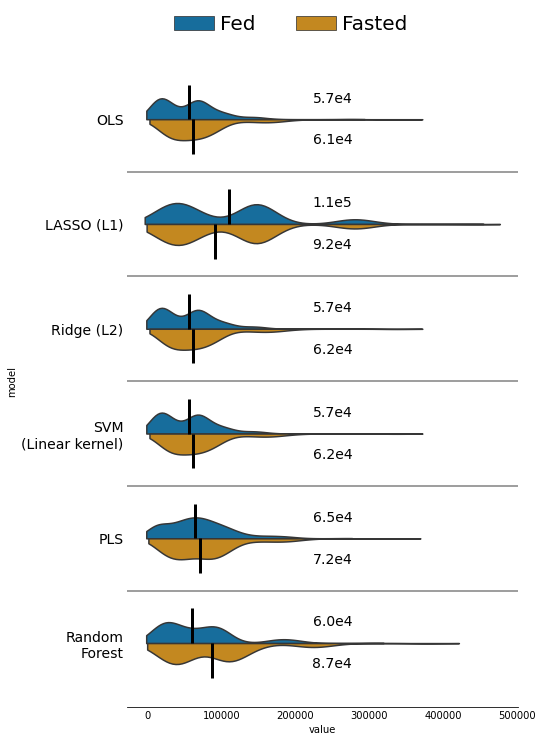

In [231]:
plot_comparison(y='insulin', error='neg_mean_squared_error',
                width=0.4, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=True)

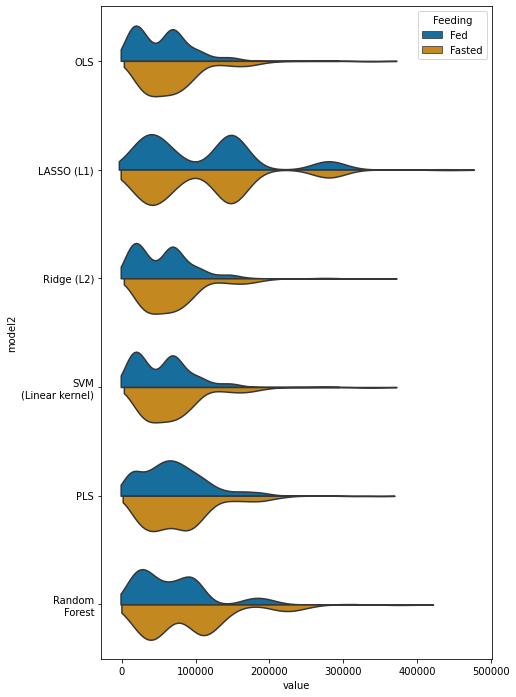

In [129]:
fig, ax = plt.subplots(figsize=(7, 12))
vp = sns.violinplot(
    data=insulin, x='value', y='model2',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

In [7]:
lasso['model'] = 'lasso'
rf['model'] = 'rf'
svr['model'] = 'model'
concat = pd.concat([lasso, rf, svr])
concat['Feeding'] = concat['variable'].map({'FBG': 'Fasted', 'RBG': 'Random-fed'})
concat

,variable,value,dummy,model,Feeding
0,FBG,0.376486,dummy,lasso,Fasted
1,FBG,0.194368,dummy,lasso,Fasted
2,FBG,0.286964,dummy,lasso,Fasted
3,FBG,0.366897,dummy,lasso,Fasted
4,FBG,0.168847,dummy,lasso,Fasted
...,...,...,...,...,...
595,RBG,0.161203,dummy,model,Random-fed
596,RBG,0.153347,dummy,model,Random-fed
597,RBG,0.122726,dummy,model,Random-fed
598,RBG,0.461233,dummy,model,Random-fed


In [98]:
d = {}
for df, name in zip([lasso, rf, svr], ['lasso', 'rf', 'svr']):
    d[name] = {}
    d[name]['rbg_mean'] = df.loc[df['variable'] == 'RBG', 'value'].mean()
    d[name]['fbg_mean'] = df.loc[df['variable'] == 'FBG', 'value'].mean()

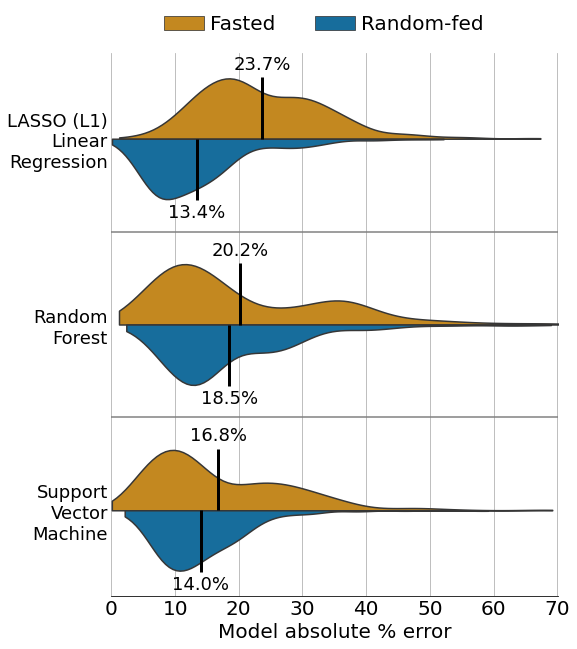

In [111]:
fig, ax = plt.subplots(figsize=(8, 10))

vp = sns.violinplot(
    data=concat, x='value', y='model',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

for i, model in enumerate(['lasso', 'rf', 'svr']):
    fbg_mean = d[model]['fbg_mean']
    rbg_mean = d[model]['rbg_mean']
    plt.plot([fbg_mean, fbg_mean], [i, i - 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.plot([rbg_mean, rbg_mean], [i, i + 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.annotate(str(round(fbg_mean*100, 1)) + '%', xy=(fbg_mean, i - 0.4), ha='center', va='center', fontsize=18)
    plt.annotate(str(round(rbg_mean*100, 1)) + '%', xy=(rbg_mean, i + 0.4), ha='center', va='center', fontsize=18)
plt.axhline(y=0.5, color='gray')
plt.axhline(y=1.5, color='gray')
plt.xlim(0, 0.701)
plt.xticks(ticks=plt.xticks()[0][:-1], labels=[str(x) for x in range(0, 80, 10)], fontsize=20)
plt.xlabel('Model absolute % error', fontsize=20)
# plt.ylabel('Model', fontsize=18)
plt.ylabel(None)
plt.yticks(ticks=[0,1,2], 
           labels=['LASSO (L1)\nLinear\nRegression', 'Random\nForest', 'Support\nVector\nMachine'],
           fontsize=18, ha='right')
plt.tick_params(axis='both', length=0)
plt.grid(axis='x', visible=None, ) 
ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
sns.despine(left=True, bottom=False)

plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
vp = sns.violinplot(
data=errors, x='value', y='dummy',
orient='h', split=True, hue='variable',
scale='width', cut=0.4,
palette=colors, 
inner=None, 
ax=ax
)
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=18, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.93), 
             ha='center', va='center', fontsize=18)

ax.set_yticks([])
ax.set_xlim((0, ax.get_xlim()[1]))
# ax.set_xticks(ticks=ax.get_xticks()[:-1], labels=[int(x*100) for x in ax.get_xticks()][:-1], fontsize=16)
ax.set_xticks(ticks=np.arange(0, 0.75, 0.1), labels=range(0, 80, 10), fontsize=16)
ax.tick_params(axis='x', length=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.get_legend().remove()
plt.grid()

sns.despine(left=True, bottom=True, ax=ax)
